# RUL Prediction (Remaining Useful Life)

Dieses Notebook trainiert Modelle zur Vorhersage der Restlebensdauer:

1. **Gradient Boosting** - Klassisches ML
2. **LSTM Neural Network** - Deep Learning für Zeitreihen
3. **CNN-LSTM Hybrid** - Kombiniert lokale und temporale Features

Die Modelle werden für den Export nach ONNX/TensorFlow.js vorbereitet.

In [1]:
# Installation
# !pip install numpy pandas scikit-learn matplotlib tensorflow xgboost lightgbm

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

import os
os.makedirs('../models/trained', exist_ok=True)
os.makedirs('../data/simulated', exist_ok=True)

print("Setup abgeschlossen!")

Setup abgeschlossen!


## 1. Daten laden oder generieren

In [3]:
DATA_DIR = '../data/simulated'

try:
    df = pd.read_csv(f'{DATA_DIR}/rul_dataset.csv')
    print(f"RUL-Datensatz geladen: {len(df)} Samples")
except FileNotFoundError:
    print("Datensatz nicht gefunden! Generiere Beispieldaten...")
    
    # Einfache RUL-Simulation
    np.random.seed(42)
    
    all_data = []
    n_units = 30
    
    for unit_id in range(n_units):
        n_cycles = np.random.randint(150, 350)
        
        for cycle in range(n_cycles):
            # Degradation simulieren
            progress = cycle / n_cycles
            
            # Features die mit der Zeit degradieren
            features = {
                'unit_id': unit_id,
                'cycle': cycle,
                'rms': 0.5 + 0.5 * progress + np.random.normal(0, 0.05),
                'peak': 1.0 + 1.0 * progress + np.random.normal(0, 0.1),
                'crest_factor': 2.0 + 0.5 * progress + np.random.normal(0, 0.1),
                'kurtosis': 3.0 + 2.0 * progress**2 + np.random.normal(0, 0.2),
                'temperature': 60 + 30 * progress + np.random.normal(0, 2),
                'current': 10 + 5 * progress + np.random.normal(0, 0.5),
                'spectral_centroid': 100 + 50 * progress + np.random.normal(0, 5),
                'band_0_100': 0.3 + 0.2 * progress + np.random.normal(0, 0.02),
                'band_100_200': 0.2 + 0.3 * progress + np.random.normal(0, 0.02),
                'health_index': 100 * (1 - progress) + np.random.normal(0, 2),
                'rul': n_cycles - cycle  # Remaining Useful Life
            }
            all_data.append(features)
    
    df = pd.DataFrame(all_data)
    df.to_csv(f'{DATA_DIR}/rul_dataset.csv', index=False)
    print(f"Datensatz generiert: {len(df)} Samples")

print(f"\nEinheiten: {df['unit_id'].nunique()}")
print(f"RUL Bereich: {df['rul'].min():.0f} - {df['rul'].max():.0f}")

RUL-Datensatz geladen: 8232 Samples

Einheiten: 30
RUL Bereich: 0 - 396


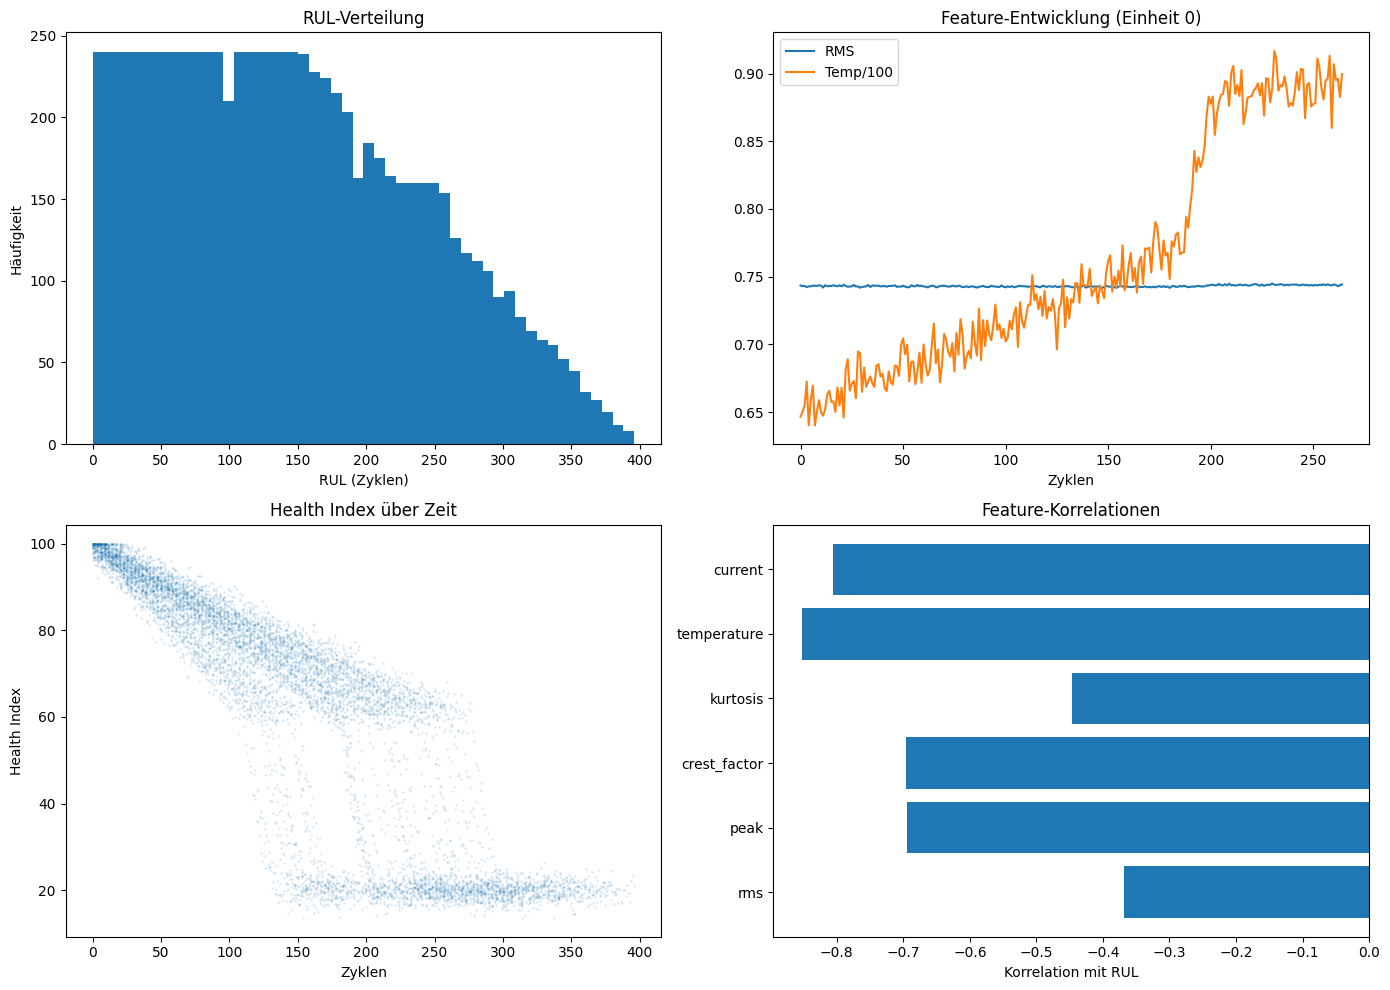

In [4]:
# Daten visualisieren
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# RUL-Verteilung
axes[0, 0].hist(df['rul'], bins=50)
axes[0, 0].set_xlabel('RUL (Zyklen)')
axes[0, 0].set_ylabel('Häufigkeit')
axes[0, 0].set_title('RUL-Verteilung')

# Feature vs RUL für eine Einheit
unit_0 = df[df['unit_id'] == 0]
axes[0, 1].plot(unit_0['cycle'], unit_0['rms'], label='RMS')
axes[0, 1].plot(unit_0['cycle'], unit_0['temperature']/100, label='Temp/100')
axes[0, 1].set_xlabel('Zyklen')
axes[0, 1].set_title('Feature-Entwicklung (Einheit 0)')
axes[0, 1].legend()

# Health Index vs Cycle
axes[1, 0].scatter(df['cycle'], df['health_index'], alpha=0.1, s=1)
axes[1, 0].set_xlabel('Zyklen')
axes[1, 0].set_ylabel('Health Index')
axes[1, 0].set_title('Health Index über Zeit')

# Korrelation RUL vs Features
feature_cols = ['rms', 'peak', 'crest_factor', 'kurtosis', 'temperature', 'current']
correlations = df[feature_cols + ['rul']].corr()['rul'].drop('rul')
axes[1, 1].barh(feature_cols, correlations)
axes[1, 1].set_xlabel('Korrelation mit RUL')
axes[1, 1].set_title('Feature-Korrelationen')

plt.tight_layout()
plt.savefig('../models/trained/rul_data_overview.png', dpi=150)
plt.show()

## 2. Daten vorbereiten

In [5]:
# Feature-Auswahl
feature_cols = [col for col in df.columns if col not in ['unit_id', 'cycle', 'rul', 'health_index']]
print(f"Features ({len(feature_cols)}): {feature_cols}")

# RUL cappen (sehr hohe RUL-Werte sind weniger relevant)
RUL_CAP = 125
df['rul_capped'] = df['rul'].clip(upper=RUL_CAP)

print(f"\nRUL gecappt bei {RUL_CAP}")

Features (15): ['rms', 'peak', 'crest_factor', 'std', 'kurtosis', 'skewness', 'spectral_centroid', 'spectral_spread', 'band_0_100', 'band_100_200', 'band_200_500', 'band_500_1000', 'band_1000_3000', 'temperature', 'current']

RUL gecappt bei 125


In [6]:
# Train/Test Split nach Einheiten (wichtig: keine Datenleckage!)
units = df['unit_id'].unique()
np.random.shuffle(units)

train_units = units[:int(0.8 * len(units))]
test_units = units[int(0.8 * len(units)):]

df_train = df[df['unit_id'].isin(train_units)]
df_test = df[df['unit_id'].isin(test_units)]

print(f"Training: {len(df_train)} Samples ({len(train_units)} Einheiten)")
print(f"Test: {len(df_test)} Samples ({len(test_units)} Einheiten)")

Training: 6808 Samples (24 Einheiten)
Test: 1424 Samples (6 Einheiten)


In [7]:
# Features und Target extrahieren
X_train = df_train[feature_cols].values
y_train = df_train['rul_capped'].values

X_test = df_test[feature_cols].values
y_test = df_test['rul_capped'].values

# Skalierung
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"X_train shape: {X_train_scaled.shape}")
print(f"y_train shape: {y_train.shape}")

X_train shape: (6808, 15)
y_train shape: (6808,)


## 3. Gradient Boosting Regressor

In [8]:
from sklearn.ensemble import GradientBoostingRegressor

print("Training Gradient Boosting...")

gb_model = GradientBoostingRegressor(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42
)

gb_model.fit(X_train_scaled, y_train)

# Prediction
y_pred_gb = gb_model.predict(X_test_scaled)

# Evaluation
print("\n=== Gradient Boosting ===")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_gb)):.2f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_gb):.2f}")
print(f"R²: {r2_score(y_test, y_pred_gb):.4f}")

Training Gradient Boosting...



=== Gradient Boosting ===
RMSE: 18.35
MAE: 11.83
R²: 0.7990


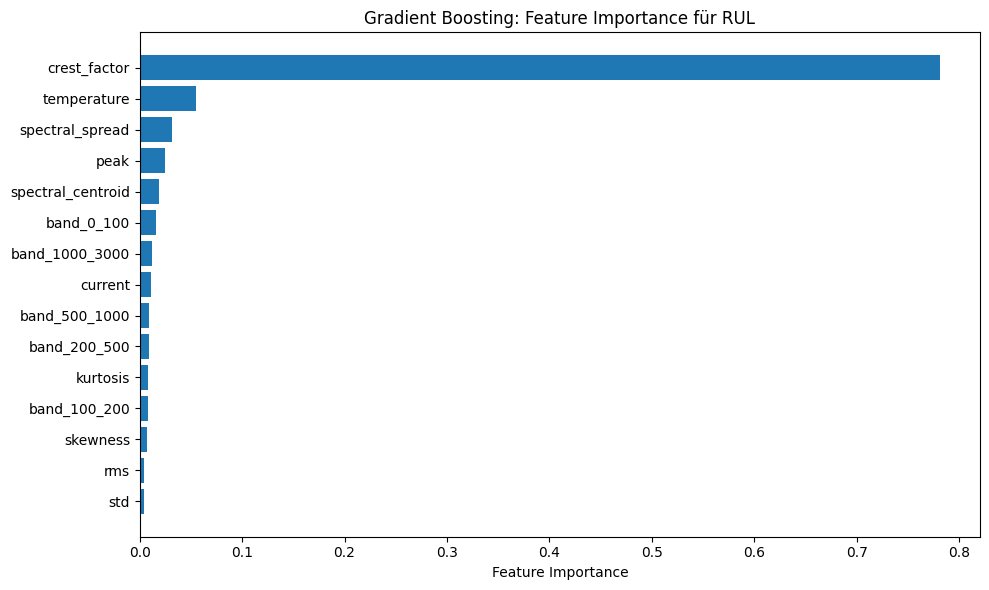

In [9]:
# Feature Importance
importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': gb_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance['feature'], importance['importance'])
plt.xlabel('Feature Importance')
plt.title('Gradient Boosting: Feature Importance für RUL')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('../models/trained/gb_feature_importance.png', dpi=150)
plt.show()

## 4. LSTM Neural Network

In [10]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(f"TensorFlow Version: {tf.__version__}")

2026-01-18 17:00:09.272544: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2026-01-18 17:00:09.280363: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2026-01-18 17:00:09.289759: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768752009.315249   78894 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768752009.323255   78894 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768752009.350261   78894 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

TensorFlow Version: 2.19.0


In [11]:
def create_sequences(df, feature_cols, target_col, sequence_length=30):
    """
    Erstellt Sequenzen für LSTM aus dem DataFrame.
    Gruppiert nach unit_id.
    """
    X_sequences = []
    y_sequences = []
    
    for unit_id in df['unit_id'].unique():
        unit_data = df[df['unit_id'] == unit_id].sort_values('cycle')
        
        X_unit = unit_data[feature_cols].values
        y_unit = unit_data[target_col].values
        
        # Sequenzen erstellen
        for i in range(sequence_length, len(unit_data)):
            X_sequences.append(X_unit[i-sequence_length:i])
            y_sequences.append(y_unit[i])
    
    return np.array(X_sequences), np.array(y_sequences)

# Sequenzen erstellen
SEQUENCE_LENGTH = 30

# Skalierung auf DataFrame anwenden
df_train_scaled = df_train.copy()
df_test_scaled = df_test.copy()

df_train_scaled[feature_cols] = scaler.fit_transform(df_train[feature_cols])
df_test_scaled[feature_cols] = scaler.transform(df_test[feature_cols])

X_train_seq, y_train_seq = create_sequences(df_train_scaled, feature_cols, 'rul_capped', SEQUENCE_LENGTH)
X_test_seq, y_test_seq = create_sequences(df_test_scaled, feature_cols, 'rul_capped', SEQUENCE_LENGTH)

print(f"Training Sequenzen: {X_train_seq.shape}")
print(f"Test Sequenzen: {X_test_seq.shape}")

Training Sequenzen: (6088, 30, 15)
Test Sequenzen: (1244, 30, 15)


In [12]:
def create_lstm_model(sequence_length, n_features):
    """
    Erstellt ein LSTM-Modell für RUL-Prediction.
    """
    model = keras.Sequential([
        layers.Input(shape=(sequence_length, n_features)),
        
        # LSTM Layers
        layers.LSTM(64, return_sequences=True),
        layers.Dropout(0.2),
        layers.LSTM(32, return_sequences=False),
        layers.Dropout(0.2),
        
        # Dense Layers
        layers.Dense(32, activation='relu'),
        layers.Dense(16, activation='relu'),
        layers.Dense(1)  # RUL Output
    ])
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )
    
    return model

# Modell erstellen
n_features = len(feature_cols)
lstm_model = create_lstm_model(SEQUENCE_LENGTH, n_features)
lstm_model.summary()

2026-01-18 17:00:12.278947: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 64)         │        20,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,497 (134.75 KB)

 Trainable params: 34,497 (134.75 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Training
print("Training LSTM...")

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6
)

history = lstm_model.fit(
    X_train_seq, y_train_seq,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Training LSTM...


Epoch 1/100


  1/172 ━━━━━━━━━━━━━━━━━━━━ 9:56 3s/step - loss: 10024.4990 - mae: 90.8049

  4/172 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 10870.1304 - mae: 96.1986

  7/172 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 10996.3489 - mae: 97.1406

 10/172 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 10920.4446 - mae: 96.7459

 13/172 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 10847.4169 - mae: 96.3179

 16/172 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 10791.6807 - mae: 95.9824

 18/172 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 10765.1488 - mae: 95.8364

 21/172 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 10739.5404 - mae: 95.7094

 23/172 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 10719.2276 - mae: 95.5985

 25/172 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 10702.3817 - mae: 95.5013

 27/172 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 10687.9613 - mae: 95.4187

 29/172 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 10677.1705 - mae: 95.3602

 32/172 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 10663.8730 - mae: 95.2922

 35/172 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 10646.1483 - mae: 95.1876

 38/172 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 10628.4494 - mae: 95.0967

 41/172 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 10608.8279 - mae: 94.9959

 44/172 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 10589.9546 - mae: 94.8954

 47/172 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 10568.0521 - mae: 94.7796

 50/172 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 10544.1531 - mae: 94.6551

 53/172 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 10521.5958 - mae: 94.5432

 56/172 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 10497.9847 - mae: 94.4288

 59/172 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 10473.4610 - mae: 94.3117

 62/172 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 10446.9567 - mae: 94.1847

 65/172 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 10420.0378 - mae: 94.0550

 68/172 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 10391.4885 - mae: 93.9148

 71/172 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 10361.1340 - mae: 93.7641

 74/172 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 10329.0438 - mae: 93.6038

 77/172 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 10296.2591 - mae: 93.4391

 80/172 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 10262.7332 - mae: 93.2706

 83/172 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 10227.9117 - mae: 93.0945

 85/172 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 10204.6700 - mae: 92.9782

 88/172 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 10169.5623 - mae: 92.8042

 91/172 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 10133.5381 - mae: 92.6251

 94/172 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 10096.7515 - mae: 92.4419

 97/172 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 10058.5550 - mae: 92.2475

100/172 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 10019.4085 - mae: 92.0467

103/172 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 9979.5455 - mae: 91.8414 

106/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 9938.4527 - mae: 91.6266

109/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 9896.3942 - mae: 91.4056

112/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 9853.2742 - mae: 91.1766

115/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 9808.9843 - mae: 90.9377

118/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 9763.5624 - mae: 90.6887

121/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 9717.1233 - mae: 90.4309

124/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 9669.7822 - mae: 90.1648

128/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 9605.5042 - mae: 89.7991

131/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 9556.3805 - mae: 89.5153

134/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 9506.6084 - mae: 89.2243

137/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 9456.2799 - mae: 88.9269

140/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 9405.4261 - mae: 88.6228

143/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 9354.0911 - mae: 88.3119

146/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 9302.3729 - mae: 87.9952

149/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 9250.3277 - mae: 87.6725

152/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 9198.0244 - mae: 87.3446

155/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 9145.5471 - mae: 87.0120

158/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 9092.9576 - mae: 86.6750

161/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 9040.3504 - mae: 86.3347

164/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 8987.8023 - mae: 85.9913

167/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 8935.3633 - mae: 85.6455

170/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 8883.0815 - mae: 85.2976

172/172 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 5905.3315 - mae: 65.3431 - val_loss: 771.9251 - val_mae: 21.9665 - learning_rate: 0.0010


Epoch 2/100


  1/172 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - loss: 461.1819 - mae: 18.4842

  4/172 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 603.3030 - mae: 19.7046

  7/172 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 606.3563 - mae: 19.5407

 10/172 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 624.2251 - mae: 19.6919

 13/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 626.9739 - mae: 19.6585

 16/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 625.9673 - mae: 19.5965

 19/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 623.1624 - mae: 19.5261

 22/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 620.5203 - mae: 19.4661

 25/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 619.4207 - mae: 19.4229

 28/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 620.7765 - mae: 19.4174

 31/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 624.5912 - mae: 19.4449

 34/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 627.9177 - mae: 19.4788

 37/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 632.2393 - mae: 19.5228

 40/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 636.2127 - mae: 19.5634

 43/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 639.9407 - mae: 19.6005

 46/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 642.7837 - mae: 19.6295

 49/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 645.0959 - mae: 19.6509

 52/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 647.5671 - mae: 19.6788

 55/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 650.1929 - mae: 19.7124

 58/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 652.7511 - mae: 19.7466

 61/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 654.9284 - mae: 19.7764

 64/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 656.8561 - mae: 19.8056

 67/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 658.6473 - mae: 19.8356

 70/172 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 660.2329 - mae: 19.8636

 73/172 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 661.6586 - mae: 19.8895

 76/172 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 663.0175 - mae: 19.9134

 79/172 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 664.1121 - mae: 19.9337

 82/172 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 665.1131 - mae: 19.9532

 85/172 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 666.0304 - mae: 19.9718

 88/172 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 667.0017 - mae: 19.9911

 91/172 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 667.9344 - mae: 20.0097

 94/172 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 668.6089 - mae: 20.0250

 97/172 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 669.2190 - mae: 20.0394

100/172 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 669.7162 - mae: 20.0527

103/172 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 670.0701 - mae: 20.0643

106/172 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 670.2998 - mae: 20.0747

109/172 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 670.4144 - mae: 20.0829

112/172 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 670.4517 - mae: 20.0894

115/172 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 670.3330 - mae: 20.0933

117/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 670.2612 - mae: 20.0956

120/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 670.0600 - mae: 20.0977

123/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 669.8043 - mae: 20.0996

126/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 669.4047 - mae: 20.0989

129/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 668.8732 - mae: 20.0951

132/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 668.2274 - mae: 20.0892

135/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 667.4852 - mae: 20.0814

138/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 666.6611 - mae: 20.0721

141/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 665.7757 - mae: 20.0617

144/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 664.8324 - mae: 20.0497

147/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 663.9294 - mae: 20.0372

149/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 663.3940 - mae: 20.0292

151/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 663.0385 - mae: 20.0226

153/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 663.0110 - mae: 20.0182

155/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 663.3036 - mae: 20.0161

158/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 664.2599 - mae: 20.0164

161/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 666.0167 - mae: 20.0230

164/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 668.9151 - mae: 20.0382

167/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 672.9890 - mae: 20.0622

170/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 678.5731 - mae: 20.0977

172/172 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 1045.6195 - mae: 22.5043 - val_loss: 5392.2192 - val_mae: 57.3409 - learning_rate: 0.0010


Epoch 3/100


  1/172 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - loss: 4272.7734 - mae: 47.8883

  4/172 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 4923.2677 - mae: 53.0723

  7/172 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 5096.8011 - mae: 54.8167

 10/172 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 5117.6079 - mae: 55.1576

 13/172 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 5122.9771 - mae: 55.4004

 16/172 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 5100.4211 - mae: 55.4629

 19/172 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 5056.8938 - mae: 55.3970

 22/172 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 4996.3918 - mae: 55.1980

 24/172 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 4947.8601 - mae: 54.9937

 26/172 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 4892.8276 - mae: 54.7272

 28/172 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 4833.7557 - mae: 54.4154

 30/172 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 4773.2058 - mae: 54.0875

 33/172 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 4682.0954 - mae: 53.5917

 36/172 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 4590.6812 - mae: 53.0772

 39/172 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 4499.6525 - mae: 52.5525

 42/172 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 4408.7835 - mae: 52.0027

 45/172 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 4318.8129 - mae: 51.4334

 48/172 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 4230.1823 - mae: 50.8454

 51/172 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 4143.6803 - mae: 50.2428

 54/172 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 4059.6570 - mae: 49.6305

 57/172 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 3978.5185 - mae: 49.0182

 60/172 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 3900.2285 - mae: 48.4120

 63/172 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 3824.9631 - mae: 47.8186

 66/172 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 3752.6733 - mae: 47.2404

 69/172 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 3683.1319 - mae: 46.6755

 72/172 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 3616.3633 - mae: 46.1271

 75/172 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 3552.3474 - mae: 45.5968

 78/172 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 3491.0197 - mae: 45.0842

 81/172 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 3432.1002 - mae: 44.5866

 84/172 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 3375.6325 - mae: 44.1074

 87/172 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 3321.3343 - mae: 43.6430

 90/172 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 3269.0137 - mae: 43.1916

 93/172 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 3218.6352 - mae: 42.7544

 96/172 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 3170.1246 - mae: 42.3312

 99/172 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 3123.3586 - mae: 41.9207

102/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 3078.2481 - mae: 41.5224

105/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 3034.6271 - mae: 41.1340

108/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 2992.4647 - mae: 40.7565

111/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 2951.7318 - mae: 40.3902

114/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 2912.3659 - mae: 40.0349

117/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 2874.2659 - mae: 39.6891

120/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 2837.3457 - mae: 39.3522

123/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 2801.6055 - mae: 39.0251

126/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 2766.9376 - mae: 38.7063

129/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 2733.3164 - mae: 38.3960

132/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 2700.7204 - mae: 38.0940

135/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 2669.1184 - mae: 37.8003

137/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 2648.5846 - mae: 37.6090

140/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 2618.4963 - mae: 37.3274

143/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 2589.2315 - mae: 37.0524

146/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 2560.7903 - mae: 36.7844

149/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 2533.1846 - mae: 36.5242

152/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 2506.3807 - mae: 36.2712

155/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 2480.2855 - mae: 36.0241

158/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 2454.8748 - mae: 35.7826

161/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 2430.1422 - mae: 35.5473

164/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 2406.0557 - mae: 35.3181

167/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 2382.5909 - mae: 35.0944

170/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 2359.7400 - mae: 34.8766

172/172 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 1077.6222 - mae: 22.6363 - val_loss: 432.4465 - val_mae: 14.9686 - learning_rate: 0.0010


Epoch 4/100


  1/172 ━━━━━━━━━━━━━━━━━━━━ 3:37 1s/step - loss: 432.3299 - mae: 15.8403

  4/172 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 344.6358 - mae: 13.5821

  7/172 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 324.9784 - mae: 13.1743

 10/172 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 326.8853 - mae: 13.3952

 13/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 329.3473 - mae: 13.6008

 16/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 330.0559 - mae: 13.7286

 19/172 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 330.5171 - mae: 13.8267

 22/172 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 330.1035 - mae: 13.8685

 25/172 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 330.7902 - mae: 13.9191

 28/172 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 331.9104 - mae: 13.9679

 31/172 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 332.9548 - mae: 14.0130

 34/172 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 333.8409 - mae: 14.0552

 37/172 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 334.3954 - mae: 14.0896

 40/172 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 334.8106 - mae: 14.1178

 43/172 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 335.0772 - mae: 14.1370

 46/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 335.4463 - mae: 14.1570

 49/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 335.6186 - mae: 14.1701

 52/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 335.7864 - mae: 14.1812

 55/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 335.7921 - mae: 14.1881

 57/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 335.8775 - mae: 14.1941

 60/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 335.8725 - mae: 14.1995

 63/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 335.8407 - mae: 14.2039

 66/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 335.7500 - mae: 14.2064

 69/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 335.5877 - mae: 14.2080

 72/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 335.3913 - mae: 14.2085

 75/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 335.1148 - mae: 14.2077

 78/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 334.9174 - mae: 14.2074

 81/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 334.6757 - mae: 14.2060

 84/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 334.4861 - mae: 14.2057

 87/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 334.3150 - mae: 14.2053

 90/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 334.2000 - mae: 14.2055

 93/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 334.0971 - mae: 14.2062

 96/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 333.9442 - mae: 14.2057

 99/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 333.8432 - mae: 14.2065

102/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 333.7801 - mae: 14.2081

105/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 333.6761 - mae: 14.2085

108/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 333.6088 - mae: 14.2091

110/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 333.5721 - mae: 14.2095

113/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 333.4771 - mae: 14.2091

116/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 333.4049 - mae: 14.2094

119/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 333.3467 - mae: 14.2102

122/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 333.3072 - mae: 14.2114

125/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 333.2621 - mae: 14.2123

128/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 333.2113 - mae: 14.2131

131/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 333.1400 - mae: 14.2129

134/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 333.0833 - mae: 14.2128

137/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 333.0139 - mae: 14.2125

140/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 332.9312 - mae: 14.2118

143/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 332.8599 - mae: 14.2115

146/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 332.8163 - mae: 14.2114

149/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 332.7786 - mae: 14.2112

152/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 332.7335 - mae: 14.2106

155/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 332.7025 - mae: 14.2102

158/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 332.6709 - mae: 14.2100

161/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 332.6268 - mae: 14.2096

164/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 332.5651 - mae: 14.2089

167/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 332.4923 - mae: 14.2077

170/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 332.4352 - mae: 14.2070

172/172 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 328.7789 - mae: 14.1553 - val_loss: 421.3631 - val_mae: 14.4593 - learning_rate: 0.0010


Epoch 5/100


  1/172 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - loss: 437.8107 - mae: 15.2512

  4/172 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 373.5355 - mae: 14.3373

  7/172 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 341.8067 - mae: 13.8958

 10/172 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 327.8352 - mae: 13.7545

 13/172 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 324.4490 - mae: 13.7475

 16/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 321.8208 - mae: 13.7551

 19/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 318.9688 - mae: 13.7479

 22/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 317.3063 - mae: 13.7611

 24/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 316.8610 - mae: 13.7823

 27/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 315.8426 - mae: 13.7941

 30/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 314.3822 - mae: 13.7891

 33/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 313.7932 - mae: 13.7950

 36/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 313.8378 - mae: 13.8138

 39/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 313.6275 - mae: 13.8208

 42/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 313.1760 - mae: 13.8197

 45/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 313.1448 - mae: 13.8238

 48/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 313.3793 - mae: 13.8310

 51/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 313.7008 - mae: 13.8394

 54/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 314.1758 - mae: 13.8506

 56/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 314.5619 - mae: 13.8587

 59/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 315.1331 - mae: 13.8703

 62/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 315.5562 - mae: 13.8772

 65/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 315.9085 - mae: 13.8822

 68/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 316.1718 - mae: 13.8844

 71/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 316.3405 - mae: 13.8847

 74/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 316.4415 - mae: 13.8841

 77/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 316.4594 - mae: 13.8823

 80/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 316.3354 - mae: 13.8771

 83/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 316.1561 - mae: 13.8713

 86/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 315.9115 - mae: 13.8640

 89/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 315.6840 - mae: 13.8571

 92/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 315.4373 - mae: 13.8499

 95/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 315.1905 - mae: 13.8425

 98/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 314.9230 - mae: 13.8345

101/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 314.6268 - mae: 13.8259

104/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 314.3270 - mae: 13.8174

107/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 314.0573 - mae: 13.8098

110/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 313.7736 - mae: 13.8021

113/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 313.5210 - mae: 13.7950

116/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 313.3318 - mae: 13.7887

119/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 313.1538 - mae: 13.7830

122/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 312.9570 - mae: 13.7770

125/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 312.7704 - mae: 13.7714

128/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 312.5776 - mae: 13.7658

131/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 312.4585 - mae: 13.7621

134/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 312.3434 - mae: 13.7584

137/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 312.2239 - mae: 13.7547

140/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 312.1044 - mae: 13.7513

143/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 312.0056 - mae: 13.7481

146/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 311.9524 - mae: 13.7461

149/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 311.9286 - mae: 13.7446

152/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 311.8868 - mae: 13.7426

155/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 311.8329 - mae: 13.7405

158/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 311.7858 - mae: 13.7388

160/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 311.7613 - mae: 13.7380

163/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 311.7183 - mae: 13.7367

166/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 311.6744 - mae: 13.7354

169/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 311.6336 - mae: 13.7343

172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 311.6176 - mae: 13.7337

172/172 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 310.5867 - mae: 13.6920 - val_loss: 409.7150 - val_mae: 14.8274 - learning_rate: 0.0010


Epoch 6/100


  1/172 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - loss: 197.1529 - mae: 11.0161

  4/172 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 234.4532 - mae: 12.0066

  7/172 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 248.1775 - mae: 12.3739

 10/172 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 258.6899 - mae: 12.6454

 13/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 264.9032 - mae: 12.8240

 16/172 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 272.7580 - mae: 13.0080

 19/172 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 278.8193 - mae: 13.1469

 22/172 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 284.1189 - mae: 13.2525

 25/172 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 287.4553 - mae: 13.3143

 28/172 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 289.9203 - mae: 13.3628

 31/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 291.2120 - mae: 13.3878

 34/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 291.8905 - mae: 13.4012

 37/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 292.2017 - mae: 13.4066

 40/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 292.3179 - mae: 13.4097

 43/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 292.7297 - mae: 13.4202

 46/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 293.3410 - mae: 13.4362

 49/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 293.7886 - mae: 13.4496

 52/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 294.0487 - mae: 13.4570

 55/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 294.2538 - mae: 13.4631

 58/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 294.4142 - mae: 13.4679

 61/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 294.4387 - mae: 13.4687

 63/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 294.5210 - mae: 13.4703

 66/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 294.6043 - mae: 13.4718

 68/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 294.6604 - mae: 13.4734

 71/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 294.7461 - mae: 13.4763

 74/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 294.8901 - mae: 13.4798

 77/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 295.0193 - mae: 13.4836

 80/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 295.0476 - mae: 13.4848

 83/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 295.0712 - mae: 13.4866

 86/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 295.0410 - mae: 13.4876

 89/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 295.0337 - mae: 13.4891

 92/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 294.9723 - mae: 13.4891

 95/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 294.8603 - mae: 13.4880

 97/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 294.7550 - mae: 13.4864

100/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 294.6038 - mae: 13.4841

103/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 294.4428 - mae: 13.4813

106/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 294.2954 - mae: 13.4784

109/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 294.1382 - mae: 13.4752

112/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 293.9603 - mae: 13.4711

115/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 293.8162 - mae: 13.4678

118/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 293.6702 - mae: 13.4641

121/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 293.5831 - mae: 13.4610

124/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 293.5277 - mae: 13.4589

127/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 293.4474 - mae: 13.4564

130/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 293.3665 - mae: 13.4540

133/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 293.3491 - mae: 13.4531

136/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 293.3477 - mae: 13.4528

139/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 293.3287 - mae: 13.4520

142/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 293.3322 - mae: 13.4518

145/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 293.3371 - mae: 13.4516

148/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 293.3679 - mae: 13.4523

151/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 293.4257 - mae: 13.4537

154/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 293.4770 - mae: 13.4550

157/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 293.5180 - mae: 13.4560

160/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 293.5853 - mae: 13.4573

163/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 293.6602 - mae: 13.4586

166/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 293.7452 - mae: 13.4600

169/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 293.8249 - mae: 13.4613

172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 293.9006 - mae: 13.4625

172/172 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 298.0854 - mae: 13.5284 - val_loss: 406.8001 - val_mae: 15.1659 - learning_rate: 0.0010


Epoch 7/100


  1/172 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - loss: 353.8481 - mae: 15.0276

  4/172 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 296.7524 - mae: 13.4679

  7/172 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 294.9796 - mae: 13.2374

 10/172 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 295.9801 - mae: 13.2420

 13/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 294.1356 - mae: 13.1902

 16/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 293.2027 - mae: 13.1698

 19/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 291.3355 - mae: 13.1357

 22/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 290.1206 - mae: 13.1313

 25/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 288.9086 - mae: 13.1231

 28/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 287.8288 - mae: 13.1084

 31/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 286.7686 - mae: 13.0878

 34/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 285.6973 - mae: 13.0621

 37/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 284.7046 - mae: 13.0396

 40/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 283.8227 - mae: 13.0175

 43/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 283.1632 - mae: 12.9968

 46/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 282.6099 - mae: 12.9798

 49/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 282.3276 - mae: 12.9699

 52/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 282.2832 - mae: 12.9676

 54/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 282.4723 - mae: 12.9727

 56/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 282.7021 - mae: 12.9795

 59/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 282.8999 - mae: 12.9861

 61/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 282.9617 - mae: 12.9885

 63/172 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 283.0753 - mae: 12.9926

 65/172 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 283.2267 - mae: 12.9974

 68/172 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 283.4142 - mae: 13.0038

 71/172 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 283.6497 - mae: 13.0114

 74/172 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 283.8830 - mae: 13.0188

 77/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 284.1473 - mae: 13.0279

 80/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 284.4398 - mae: 13.0383

 83/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 284.7269 - mae: 13.0485

 86/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 284.9818 - mae: 13.0578

 89/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 285.2466 - mae: 13.0674

 92/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 285.5005 - mae: 13.0769

 95/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 285.7316 - mae: 13.0863

 98/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 286.0251 - mae: 13.0973

101/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 286.3072 - mae: 13.1083

104/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 286.5854 - mae: 13.1186

107/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 286.8263 - mae: 13.1274

110/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 287.0275 - mae: 13.1351

113/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 287.2566 - mae: 13.1428

116/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 287.5331 - mae: 13.1519

119/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 287.7934 - mae: 13.1606

122/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 288.0140 - mae: 13.1681

125/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 288.2453 - mae: 13.1758

128/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 288.4866 - mae: 13.1831

130/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 288.6589 - mae: 13.1883

133/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 288.8718 - mae: 13.1948

136/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 289.0634 - mae: 13.2004

139/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 289.2391 - mae: 13.2053

142/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 289.3918 - mae: 13.2097

145/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 289.5355 - mae: 13.2140

148/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 289.6822 - mae: 13.2185

151/172 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 289.8136 - mae: 13.2226

154/172 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 289.9501 - mae: 13.2268

157/172 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 290.0752 - mae: 13.2308

160/172 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 290.2027 - mae: 13.2348

163/172 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 290.3115 - mae: 13.2385

166/172 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 290.4017 - mae: 13.2418

169/172 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 290.4966 - mae: 13.2452

172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 290.6060 - mae: 13.2490

172/172 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 296.7286 - mae: 13.4640 - val_loss: 394.5400 - val_mae: 15.4577 - learning_rate: 0.0010


Epoch 8/100


  1/172 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - loss: 214.2303 - mae: 9.8364

  4/172 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 232.6070 - mae: 11.4487

  7/172 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 247.9193 - mae: 12.0645

 10/172 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 259.4111 - mae: 12.4112

 13/172 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 264.4739 - mae: 12.5402

 16/172 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 267.8077 - mae: 12.6362

 19/172 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 269.9984 - mae: 12.7135

 22/172 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 271.8010 - mae: 12.7794

 25/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 273.6394 - mae: 12.8392

 28/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 275.2405 - mae: 12.8823

 31/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 276.3812 - mae: 12.9162

 34/172 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 276.9551 - mae: 12.9394

 36/172 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 277.2730 - mae: 12.9530

 38/172 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 277.4047 - mae: 12.9623

 40/172 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 277.5724 - mae: 12.9704

 43/172 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 277.6503 - mae: 12.9746

 46/172 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 278.0303 - mae: 12.9789

 49/172 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 278.2923 - mae: 12.9795

 53/172 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 278.7239 - mae: 12.9843

 56/172 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 279.2411 - mae: 12.9923

 59/172 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 279.8759 - mae: 13.0032

 62/172 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 280.4820 - mae: 13.0135

 65/172 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 281.0013 - mae: 13.0231

 68/172 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 281.4615 - mae: 13.0318

 71/172 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 281.9060 - mae: 13.0406

 74/172 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 282.4719 - mae: 13.0527

 78/172 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 283.1156 - mae: 13.0662

 81/172 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 283.4289 - mae: 13.0730

 84/172 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 283.6051 - mae: 13.0768

 87/172 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 283.7278 - mae: 13.0797

 90/172 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 283.8121 - mae: 13.0810

 93/172 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 283.8604 - mae: 13.0816

 96/172 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 283.8496 - mae: 13.0813

 99/172 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 283.7873 - mae: 13.0796

102/172 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 283.7346 - mae: 13.0786

105/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 283.6690 - mae: 13.0780

108/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 283.6222 - mae: 13.0779

111/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 283.5631 - mae: 13.0772

114/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 283.4992 - mae: 13.0761

117/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 283.4249 - mae: 13.0748

120/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 283.3675 - mae: 13.0739

123/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 283.3403 - mae: 13.0736

126/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 283.3122 - mae: 13.0735

129/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 283.2858 - mae: 13.0734

132/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 283.2290 - mae: 13.0725

135/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 283.1927 - mae: 13.0721

138/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 283.1834 - mae: 13.0722

141/172 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 283.1881 - mae: 13.0725

143/172 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 283.1830 - mae: 13.0724

146/172 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 283.1781 - mae: 13.0725

149/172 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 283.1730 - mae: 13.0726

152/172 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 283.2011 - mae: 13.0736

155/172 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 283.2410 - mae: 13.0749

158/172 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 283.2887 - mae: 13.0766

161/172 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 283.3491 - mae: 13.0784

164/172 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 283.4340 - mae: 13.0804

167/172 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 283.5090 - mae: 13.0822

170/172 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 283.5737 - mae: 13.0838

172/172 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 287.4584 - mae: 13.1819 - val_loss: 414.7112 - val_mae: 16.5111 - learning_rate: 0.0010


Epoch 9/100


  1/172 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - loss: 250.1405 - mae: 13.2626

  4/172 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 272.7673 - mae: 12.9640

  7/172 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 265.8904 - mae: 12.7466

 10/172 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 266.5145 - mae: 12.7643

 13/172 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 271.9005 - mae: 12.8752

 16/172 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 275.8219 - mae: 12.9713

 19/172 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 277.1449 - mae: 13.0141

 22/172 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 277.1053 - mae: 13.0152

 25/172 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 277.0893 - mae: 13.0110

 28/172 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 276.8329 - mae: 12.9978

 31/172 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 276.4048 - mae: 12.9850

 34/172 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 276.2716 - mae: 12.9811

 37/172 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 276.1282 - mae: 12.9805

 40/172 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 275.8194 - mae: 12.9768

 43/172 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 275.5758 - mae: 12.9738

 46/172 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 275.3887 - mae: 12.9732

 49/172 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 275.1835 - mae: 12.9711

 52/172 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 275.0058 - mae: 12.9714

 55/172 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 274.9162 - mae: 12.9739

 58/172 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 274.8386 - mae: 12.9753

 61/172 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 274.9134 - mae: 12.9786

 64/172 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 275.0229 - mae: 12.9825

 67/172 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 275.1010 - mae: 12.9859

 70/172 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 275.1663 - mae: 12.9889

 73/172 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 275.2327 - mae: 12.9922

 76/172 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 275.3270 - mae: 12.9964

 79/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 275.4536 - mae: 13.0011

 82/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 275.6669 - mae: 13.0065

 85/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 275.8264 - mae: 13.0104

 88/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 276.0572 - mae: 13.0166

 91/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 276.3219 - mae: 13.0239

 94/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 276.6319 - mae: 13.0321

 97/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 276.9862 - mae: 13.0409

100/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 277.2933 - mae: 13.0485

102/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 277.4527 - mae: 13.0520

105/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 277.6434 - mae: 13.0564

107/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 277.7424 - mae: 13.0587

110/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 277.8607 - mae: 13.0616

113/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 277.9972 - mae: 13.0646

116/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 278.1182 - mae: 13.0671

118/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 278.1845 - mae: 13.0686

121/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 278.3160 - mae: 13.0719

124/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 278.4775 - mae: 13.0757

127/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 278.6489 - mae: 13.0799

130/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 278.8342 - mae: 13.0843

132/172 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 278.9665 - mae: 13.0869

134/172 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 279.1237 - mae: 13.0899

137/172 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 279.3607 - mae: 13.0945

139/172 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 279.5053 - mae: 13.0975

141/172 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 279.6619 - mae: 13.1009

144/172 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 279.8867 - mae: 13.1059

147/172 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 280.1012 - mae: 13.1107

150/172 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 280.3032 - mae: 13.1151

153/172 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 280.4803 - mae: 13.1188

155/172 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 280.5891 - mae: 13.1211

157/172 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 280.6968 - mae: 13.1234

159/172 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 280.8007 - mae: 13.1257

162/172 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 280.9780 - mae: 13.1295

164/172 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 281.0973 - mae: 13.1321

166/172 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 281.2174 - mae: 13.1348

169/172 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 281.3845 - mae: 13.1386

172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 281.5534 - mae: 13.1425

172/172 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 291.1526 - mae: 13.3620 - val_loss: 405.8356 - val_mae: 14.5535 - learning_rate: 0.0010


Epoch 10/100


  1/172 ━━━━━━━━━━━━━━━━━━━━ 3:09 1s/step - loss: 110.6946 - mae: 8.1468

  4/172 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 160.2439 - mae: 9.7397

  7/172 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 196.4918 - mae: 10.6561

 10/172 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 212.9372 - mae: 10.9958

 13/172 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 224.2262 - mae: 11.2285

 16/172 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 229.6201 - mae: 11.3415

 19/172 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 232.8239 - mae: 11.4226

 22/172 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 237.8022 - mae: 11.5585

 25/172 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 241.5463 - mae: 11.6700

 28/172 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 244.0757 - mae: 11.7493

 31/172 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 246.2127 - mae: 11.8195

 34/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 248.2720 - mae: 11.8851

 37/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 250.1206 - mae: 11.9451

 40/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 251.9955 - mae: 12.0087

 43/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 253.7934 - mae: 12.0703

 46/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 255.2452 - mae: 12.1217

 49/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 256.3454 - mae: 12.1613

 52/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 257.2142 - mae: 12.1922

 55/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 257.9410 - mae: 12.2186

 58/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 258.5918 - mae: 12.2427

 61/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 259.0890 - mae: 12.2622

 65/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 259.6407 - mae: 12.2849

 68/172 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 259.9962 - mae: 12.3002

 71/172 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 260.3838 - mae: 12.3154

 74/172 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 260.8344 - mae: 12.3306

 77/172 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 261.2894 - mae: 12.3457

 80/172 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 261.7319 - mae: 12.3607

 82/172 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 262.0419 - mae: 12.3713

 85/172 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 262.4972 - mae: 12.3873

 88/172 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 262.9794 - mae: 12.4045

 91/172 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 263.4418 - mae: 12.4214

 94/172 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 263.8681 - mae: 12.4373

 97/172 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 264.2709 - mae: 12.4525

100/172 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 264.6585 - mae: 12.4672

103/172 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 264.9776 - mae: 12.4799

106/172 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 265.2926 - mae: 12.4924

109/172 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 265.6092 - mae: 12.5050

112/172 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 265.9026 - mae: 12.5170

115/172 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 266.1602 - mae: 12.5280

118/172 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 266.4135 - mae: 12.5384

121/172 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 266.6569 - mae: 12.5485

124/172 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 266.8931 - mae: 12.5579

127/172 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 267.1188 - mae: 12.5669

130/172 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 267.3555 - mae: 12.5759

133/172 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 267.6383 - mae: 12.5857

136/172 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 267.9011 - mae: 12.5951

139/172 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 268.1920 - mae: 12.6050

142/172 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 268.4597 - mae: 12.6140

145/172 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 268.7152 - mae: 12.6226

148/172 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 268.9652 - mae: 12.6308

151/172 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 269.2061 - mae: 12.6388

154/172 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 269.4488 - mae: 12.6467

157/172 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 269.7046 - mae: 12.6550

160/172 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 269.9565 - mae: 12.6631

163/172 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 270.1900 - mae: 12.6708

166/172 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 270.4096 - mae: 12.6782

169/172 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 270.6510 - mae: 12.6860

172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 270.8861 - mae: 12.6936

172/172 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 284.3245 - mae: 13.1255 - val_loss: 395.8140 - val_mae: 14.9721 - learning_rate: 0.0010


Epoch 11/100


  1/172 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - loss: 382.0221 - mae: 15.3166

  4/172 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 386.4500 - mae: 15.3116

  7/172 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 369.3063 - mae: 15.0065

 10/172 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 356.7970 - mae: 14.7008

 13/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 349.9340 - mae: 14.5483

 16/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 344.8180 - mae: 14.4361

 19/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 338.8087 - mae: 14.3036

 22/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 334.2663 - mae: 14.2081

 25/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 330.3072 - mae: 14.1223

 28/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 327.2635 - mae: 14.0589

 31/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 324.4764 - mae: 14.0027

 34/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 321.9732 - mae: 13.9554

 37/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 319.9722 - mae: 13.9211

 40/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 318.4442 - mae: 13.8952

 43/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 317.3146 - mae: 13.8782

 46/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 316.5269 - mae: 13.8670

 49/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 315.9353 - mae: 13.8572

 52/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 315.3751 - mae: 13.8477

 55/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 314.7133 - mae: 13.8343

 58/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 313.9209 - mae: 13.8182

 61/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 313.1083 - mae: 13.8013

 64/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 312.3486 - mae: 13.7858

 67/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 311.6261 - mae: 13.7714

 70/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 310.9950 - mae: 13.7597

 73/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 310.4405 - mae: 13.7500

 76/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 309.8915 - mae: 13.7393

 79/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 309.4700 - mae: 13.7310

 82/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 309.0731 - mae: 13.7236

 85/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 308.6904 - mae: 13.7166

 88/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 308.3217 - mae: 13.7103

 91/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 307.9818 - mae: 13.7042

 94/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 307.6493 - mae: 13.6981

 97/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 307.2963 - mae: 13.6912

100/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 306.9548 - mae: 13.6840

103/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 306.5778 - mae: 13.6763

106/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 306.1869 - mae: 13.6680

109/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 305.8252 - mae: 13.6602

112/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 305.4711 - mae: 13.6527

115/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 305.1052 - mae: 13.6446

118/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 304.7976 - mae: 13.6378

121/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 304.5229 - mae: 13.6321

124/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 304.2598 - mae: 13.6268

127/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 303.9934 - mae: 13.6216

130/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 303.7111 - mae: 13.6157

133/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 303.4448 - mae: 13.6100

136/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 303.1824 - mae: 13.6043

139/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 302.9160 - mae: 13.5983

142/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 302.6439 - mae: 13.5922

145/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 302.3555 - mae: 13.5857

148/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 302.0727 - mae: 13.5793

151/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 301.8106 - mae: 13.5733

154/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 301.5534 - mae: 13.5673

157/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 301.3323 - mae: 13.5621

160/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 301.1215 - mae: 13.5569

164/172 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 300.8258 - mae: 13.5495

168/172 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 300.5581 - mae: 13.5428

171/172 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 300.3650 - mae: 13.5378

172/172 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 288.8409 - mae: 13.2372 - val_loss: 423.4444 - val_mae: 14.1644 - learning_rate: 0.0010


Epoch 12/100


  1/172 ━━━━━━━━━━━━━━━━━━━━ 4:32 2s/step - loss: 301.0924 - mae: 12.7375

  4/172 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 360.9110 - mae: 13.8594

  7/172 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 340.6806 - mae: 13.5957

 10/172 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 326.8566 - mae: 13.4526

 13/172 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 318.9888 - mae: 13.3748

 16/172 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 311.6179 - mae: 13.2716

 19/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 306.5127 - mae: 13.1972

 22/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 304.2625 - mae: 13.1844

 25/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 302.1129 - mae: 13.1582

 28/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 300.0506 - mae: 13.1353

 31/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 298.3824 - mae: 13.1196

 34/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 297.0186 - mae: 13.1121

 37/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 296.1679 - mae: 13.1167

 40/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 295.0104 - mae: 13.1084

 43/172 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 293.9327 - mae: 13.1002

 46/172 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 292.9225 - mae: 13.0934

 49/172 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 292.1012 - mae: 13.0881

 52/172 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 291.2728 - mae: 13.0803

 54/172 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 290.6555 - mae: 13.0738

 56/172 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 290.1328 - mae: 13.0690

 58/172 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 289.6576 - mae: 13.0646

 59/172 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 289.4485 - mae: 13.0630

 60/172 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 289.2349 - mae: 13.0613

 61/172 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 289.0220 - mae: 13.0595

 62/172 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 288.8265 - mae: 13.0579

 63/172 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 288.6455 - mae: 13.0567

 64/172 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 288.4566 - mae: 13.0553

 65/172 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 288.2707 - mae: 13.0539

 66/172 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 288.0783 - mae: 13.0523

 67/172 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 287.9059 - mae: 13.0512

 68/172 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 287.7662 - mae: 13.0506

 70/172 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 287.4924 - mae: 13.0495

 71/172 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 287.3663 - mae: 13.0489

 72/172 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 287.2129 - mae: 13.0475

 73/172 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 287.0801 - mae: 13.0464

 74/172 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 286.9499 - mae: 13.0452

 75/172 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 286.8155 - mae: 13.0437

 76/172 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 286.6748 - mae: 13.0420

 78/172 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 286.3620 - mae: 13.0376

 79/172 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 286.2099 - mae: 13.0357

 80/172 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 286.0763 - mae: 13.0341

 81/172 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 285.9285 - mae: 13.0322

 83/172 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 285.6578 - mae: 13.0292

 85/172 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 285.3960 - mae: 13.0265

 87/172 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 285.1707 - mae: 13.0247

 88/172 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 285.0352 - mae: 13.0230

 90/172 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 284.7767 - mae: 13.0196

 92/172 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 284.5315 - mae: 13.0163

 93/172 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 284.4164 - mae: 13.0146

 95/172 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 284.2000 - mae: 13.0120

 97/172 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 284.0067 - mae: 13.0100

 99/172 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 283.8174 - mae: 13.0082

101/172 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 283.6338 - mae: 13.0062

103/172 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 283.4682 - mae: 13.0046

105/172 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 283.3159 - mae: 13.0033

107/172 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 283.1606 - mae: 13.0018

109/172 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 283.0072 - mae: 13.0003

111/172 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 282.8622 - mae: 12.9987

113/172 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 282.7185 - mae: 12.9968

115/172 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 282.6095 - mae: 12.9957

117/172 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 282.4988 - mae: 12.9943

119/172 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 282.3867 - mae: 12.9929

121/172 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 282.2717 - mae: 12.9914

123/172 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 282.1307 - mae: 12.9891

125/172 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 281.9928 - mae: 12.9868

127/172 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 281.8723 - mae: 12.9847

129/172 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 281.7573 - mae: 12.9828

131/172 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 281.6412 - mae: 12.9809

133/172 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 281.5396 - mae: 12.9794

135/172 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 281.4652 - mae: 12.9782

137/172 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 281.4227 - mae: 12.9776

139/172 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 281.3785 - mae: 12.9769

141/172 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 281.3412 - mae: 12.9765

143/172 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 281.3023 - mae: 12.9761

145/172 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 281.2524 - mae: 12.9755

147/172 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 281.2037 - mae: 12.9748

150/172 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 281.1481 - mae: 12.9738

151/172 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 281.1376 - mae: 12.9736

153/172 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 281.1207 - mae: 12.9734

154/172 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 281.1194 - mae: 12.9735

156/172 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 281.1175 - mae: 12.9736

158/172 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 281.1181 - mae: 12.9737

160/172 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 281.1218 - mae: 12.9740

162/172 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 281.1225 - mae: 12.9742

165/172 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 281.1492 - mae: 12.9751

168/172 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 281.1852 - mae: 12.9761

170/172 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 281.2073 - mae: 12.9768

172/172 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - loss: 283.6892 - mae: 13.0420 - val_loss: 386.9554 - val_mae: 14.3997 - learning_rate: 0.0010


Epoch 13/100


  1/172 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - loss: 259.3457 - mae: 12.0955

  3/172 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 297.8107 - mae: 12.9937

  6/172 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 308.1643 - mae: 13.4570

  8/172 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 303.9461 - mae: 13.4518

 11/172 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 298.2377 - mae: 13.4065

 13/172 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 294.8620 - mae: 13.3658

 15/172 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 293.6495 - mae: 13.3655

 17/172 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 292.9923 - mae: 13.3699

 19/172 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 291.7673 - mae: 13.3559

 21/172 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 290.3311 - mae: 13.3316

 24/172 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 289.6286 - mae: 13.3271

 27/172 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 288.9202 - mae: 13.3164

 30/172 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 287.8203 - mae: 13.3016

 32/172 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 286.8751 - mae: 13.2833

 35/172 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 285.4296 - mae: 13.2534

 38/172 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 283.9604 - mae: 13.2204

 41/172 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 282.3636 - mae: 13.1818

 44/172 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 280.8053 - mae: 13.1443

 47/172 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 279.2893 - mae: 13.1064

 50/172 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 277.9550 - mae: 13.0712

 53/172 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 276.7406 - mae: 13.0404

 56/172 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 275.7829 - mae: 13.0157

 59/172 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 274.9021 - mae: 12.9937

 61/172 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 274.3742 - mae: 12.9808

 64/172 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 273.8233 - mae: 12.9677

 66/172 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 273.4486 - mae: 12.9582

 69/172 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 272.8307 - mae: 12.9428

 72/172 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 272.3107 - mae: 12.9297

 75/172 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 271.8005 - mae: 12.9172

 78/172 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 271.2857 - mae: 12.9033

 81/172 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 270.8370 - mae: 12.8902

 85/172 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 270.3975 - mae: 12.8768

 88/172 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 270.0963 - mae: 12.8677

 91/172 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 269.8736 - mae: 12.8602

 94/172 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 269.6641 - mae: 12.8531

 97/172 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 269.4998 - mae: 12.8472

100/172 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 269.3624 - mae: 12.8423

103/172 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 269.2691 - mae: 12.8391

106/172 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 269.2314 - mae: 12.8372

109/172 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 269.2415 - mae: 12.8360

112/172 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 269.2347 - mae: 12.8341

115/172 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 269.2482 - mae: 12.8332

118/172 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 269.2909 - mae: 12.8329

121/172 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 269.3498 - mae: 12.8328

124/172 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 269.4090 - mae: 12.8329

127/172 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 269.4722 - mae: 12.8331

130/172 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 269.5252 - mae: 12.8336

133/172 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 269.5744 - mae: 12.8337

136/172 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 269.6524 - mae: 12.8346

139/172 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 269.7159 - mae: 12.8352

141/172 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 269.7589 - mae: 12.8358

144/172 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 269.8081 - mae: 12.8365

146/172 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 269.8328 - mae: 12.8368

148/172 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 269.8531 - mae: 12.8371

151/172 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 269.8811 - mae: 12.8375

154/172 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 269.9092 - mae: 12.8377

157/172 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 269.9222 - mae: 12.8375

160/172 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 269.9173 - mae: 12.8370

162/172 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 269.9119 - mae: 12.8366

164/172 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 269.9056 - mae: 12.8363

167/172 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 269.9094 - mae: 12.8361

170/172 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 269.9283 - mae: 12.8363

172/172 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 270.7764 - mae: 12.8395 - val_loss: 410.1052 - val_mae: 16.3807 - learning_rate: 0.0010


Epoch 14/100


  1/172 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - loss: 224.2646 - mae: 11.7417

  4/172 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 312.6421 - mae: 13.8648

  7/172 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 302.2023 - mae: 13.5885

 10/172 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 291.6509 - mae: 13.3419

 13/172 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 287.2260 - mae: 13.2458

 16/172 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 286.1069 - mae: 13.2197

 19/172 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 285.7777 - mae: 13.2160

 22/172 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 285.6210 - mae: 13.2036

 25/172 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 286.9072 - mae: 13.2308

 28/172 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 288.0491 - mae: 13.2540

 31/172 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 289.6184 - mae: 13.2799

 34/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 290.7265 - mae: 13.2963

 37/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 291.2575 - mae: 13.3017

 40/172 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 291.6651 - mae: 13.3050

 43/172 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 291.9111 - mae: 13.3065

 46/172 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 291.8636 - mae: 13.3010

 49/172 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 291.9685 - mae: 13.2967

 52/172 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 292.0896 - mae: 13.2922

 55/172 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 292.0028 - mae: 13.2846

 58/172 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 291.8783 - mae: 13.2775

 61/172 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 291.7864 - mae: 13.2732

 64/172 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 291.5836 - mae: 13.2670

 67/172 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 291.3461 - mae: 13.2603

 70/172 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 291.0594 - mae: 13.2535

 73/172 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 290.7857 - mae: 13.2475

 76/172 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 290.4727 - mae: 13.2407

 79/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 290.1461 - mae: 13.2335

 82/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 289.6984 - mae: 13.2231

 85/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 289.1858 - mae: 13.2110

 88/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 288.6870 - mae: 13.1995

 91/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 288.1452 - mae: 13.1869

 94/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 287.5831 - mae: 13.1733

 97/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 287.0625 - mae: 13.1606

100/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 286.5967 - mae: 13.1489

103/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 286.1645 - mae: 13.1379

106/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 285.8983 - mae: 13.1306

109/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 285.6945 - mae: 13.1252

112/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 285.5153 - mae: 13.1206

115/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 285.3255 - mae: 13.1159

118/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 285.1626 - mae: 13.1120

121/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 285.0466 - mae: 13.1088

124/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 284.9521 - mae: 13.1058

127/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 284.8591 - mae: 13.1027

130/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 284.7653 - mae: 13.0995

133/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 284.6826 - mae: 13.0968

136/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 284.5690 - mae: 13.0935

139/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 284.4613 - mae: 13.0908

142/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 284.3275 - mae: 13.0875

145/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 284.1736 - mae: 13.0837

148/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 284.0031 - mae: 13.0796

150/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 283.8794 - mae: 13.0766

153/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 283.7009 - mae: 13.0721

156/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 283.5382 - mae: 13.0680

159/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 283.3754 - mae: 13.0640

162/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 283.2000 - mae: 13.0600

165/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 283.0347 - mae: 13.0561

168/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 282.8716 - mae: 13.0522

171/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 282.7042 - mae: 13.0480

172/172 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 273.0376 - mae: 12.8061 - val_loss: 403.9889 - val_mae: 14.7394 - learning_rate: 0.0010


Epoch 15/100


  1/172 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - loss: 232.0219 - mae: 11.4960

  4/172 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 262.1168 - mae: 12.6112

  7/172 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 264.4203 - mae: 12.6666

 10/172 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 265.5003 - mae: 12.7166

 13/172 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 270.2887 - mae: 12.8063

 16/172 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 271.2184 - mae: 12.8326

 19/172 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 271.5204 - mae: 12.8625

 22/172 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 270.9833 - mae: 12.8715

 25/172 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 271.2465 - mae: 12.8980

 28/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 271.1640 - mae: 12.9109

 31/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 270.8842 - mae: 12.9141

 34/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 270.6352 - mae: 12.9143

 37/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 270.1716 - mae: 12.9066

 40/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 269.4755 - mae: 12.8905

 43/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 268.5497 - mae: 12.8687

 46/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 267.7350 - mae: 12.8487

 49/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 266.8954 - mae: 12.8269

 52/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 266.0989 - mae: 12.8052

 55/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 265.3428 - mae: 12.7847

 58/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 264.6377 - mae: 12.7650

 61/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 264.0633 - mae: 12.7485

 64/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 263.4636 - mae: 12.7314

 67/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 262.8872 - mae: 12.7159

 70/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 262.2377 - mae: 12.6992

 73/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 261.6646 - mae: 12.6848

 76/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 261.1717 - mae: 12.6717

 79/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 260.7478 - mae: 12.6600

 82/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 260.3163 - mae: 12.6477

 85/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 259.8870 - mae: 12.6353

 88/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 259.5700 - mae: 12.6257

 91/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 259.2991 - mae: 12.6172

 94/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 259.0779 - mae: 12.6102

 97/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 258.9692 - mae: 12.6060

100/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 258.8723 - mae: 12.6018

103/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 258.7930 - mae: 12.5980

106/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 258.7248 - mae: 12.5941

109/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 258.6889 - mae: 12.5906

112/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 258.5929 - mae: 12.5856

115/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 258.4945 - mae: 12.5805

118/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 258.3763 - mae: 12.5749

121/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 258.2678 - mae: 12.5696

124/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 258.1739 - mae: 12.5647

127/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 258.1178 - mae: 12.5610

130/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 258.0438 - mae: 12.5570

133/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 257.9979 - mae: 12.5540

136/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 257.9693 - mae: 12.5514

139/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 257.9260 - mae: 12.5486

142/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 257.8577 - mae: 12.5451

145/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 257.7997 - mae: 12.5420

148/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 257.7640 - mae: 12.5396

151/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 257.7450 - mae: 12.5377

154/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 257.7344 - mae: 12.5362

157/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 257.7214 - mae: 12.5348

160/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 257.6896 - mae: 12.5327

163/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 257.6513 - mae: 12.5306

166/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 257.6080 - mae: 12.5285

169/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 257.5686 - mae: 12.5266

172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 257.5386 - mae: 12.5252

172/172 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 256.1387 - mae: 12.4500 - val_loss: 409.7325 - val_mae: 15.4217 - learning_rate: 0.0010


Epoch 16/100


  1/172 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - loss: 288.2570 - mae: 13.5183

  4/172 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 295.0224 - mae: 13.6604

  7/172 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 286.5561 - mae: 13.3994

 10/172 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 279.8045 - mae: 13.1246

 13/172 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 276.3609 - mae: 12.9768

 16/172 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 274.1765 - mae: 12.8952

 19/172 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 273.0573 - mae: 12.8661

 21/172 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 271.9166 - mae: 12.8414

 24/172 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 270.0826 - mae: 12.7993

 27/172 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 268.7210 - mae: 12.7676

 30/172 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 268.1520 - mae: 12.7486

 33/172 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 267.3662 - mae: 12.7221

 36/172 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 266.8898 - mae: 12.7013

 39/172 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 266.4565 - mae: 12.6836

 42/172 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 265.8962 - mae: 12.6663

 45/172 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 265.4228 - mae: 12.6514

 48/172 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 264.7580 - mae: 12.6326

 51/172 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 264.0797 - mae: 12.6150

 54/172 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 263.4993 - mae: 12.6003

 57/172 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 262.9317 - mae: 12.5835

 60/172 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 262.2995 - mae: 12.5637

 63/172 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 261.6825 - mae: 12.5449

 66/172 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 261.2153 - mae: 12.5309

 69/172 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 260.8347 - mae: 12.5182

 72/172 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 260.4976 - mae: 12.5068

 75/172 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 260.2008 - mae: 12.4971

 78/172 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 259.9123 - mae: 12.4884

 81/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 259.6333 - mae: 12.4801

 84/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 259.3360 - mae: 12.4721

 87/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 259.0714 - mae: 12.4652

 90/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 258.7920 - mae: 12.4582

 93/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 258.5116 - mae: 12.4516

 96/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 258.2702 - mae: 12.4458

 99/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 258.0632 - mae: 12.4413

102/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 257.8712 - mae: 12.4371

105/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 257.7044 - mae: 12.4339

108/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 257.5516 - mae: 12.4314

111/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 257.3713 - mae: 12.4279

114/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 257.2486 - mae: 12.4256

117/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 257.1349 - mae: 12.4232

120/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 257.0086 - mae: 12.4208

123/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 256.8845 - mae: 12.4185

125/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 256.8051 - mae: 12.4170

128/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 256.6833 - mae: 12.4146

130/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 256.6052 - mae: 12.4131

133/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 256.4943 - mae: 12.4108

136/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 256.4189 - mae: 12.4092

139/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 256.3572 - mae: 12.4081

142/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 256.3065 - mae: 12.4072

145/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 256.2556 - mae: 12.4063

148/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 256.2073 - mae: 12.4053

151/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 256.1672 - mae: 12.4045

154/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 256.1199 - mae: 12.4037

157/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 256.0946 - mae: 12.4033

160/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 256.0538 - mae: 12.4026

163/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 256.0092 - mae: 12.4018

166/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 255.9541 - mae: 12.4007

169/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 255.9058 - mae: 12.3999

172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 255.8528 - mae: 12.3990

172/172 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 252.7123 - mae: 12.3436 - val_loss: 429.8224 - val_mae: 15.3442 - learning_rate: 0.0010


Epoch 17/100


  1/172 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - loss: 282.0806 - mae: 13.0993

  4/172 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 276.0147 - mae: 12.6841

  7/172 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 277.6618 - mae: 12.6055

 10/172 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 276.2720 - mae: 12.5767

 13/172 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 275.1725 - mae: 12.5639

 16/172 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 276.7285 - mae: 12.5919

 19/172 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 278.4392 - mae: 12.6373

 22/172 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 278.3669 - mae: 12.6460

 25/172 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 277.6571 - mae: 12.6464

 28/172 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 276.5730 - mae: 12.6343

 30/172 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 276.1677 - mae: 12.6337

 33/172 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 275.4061 - mae: 12.6240

 36/172 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 274.6016 - mae: 12.6100

 39/172 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 273.9774 - mae: 12.6006

 42/172 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 273.2859 - mae: 12.5914

 45/172 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 272.3547 - mae: 12.5766

 49/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 270.9674 - mae: 12.5534

 52/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 270.0732 - mae: 12.5406

 55/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 269.1840 - mae: 12.5280

 59/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 268.2258 - mae: 12.5141

 62/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 267.5618 - mae: 12.5042

 65/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 266.9590 - mae: 12.4955

 68/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 266.3846 - mae: 12.4874

 71/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 265.7503 - mae: 12.4773

 74/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 265.1343 - mae: 12.4676

 77/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 264.6703 - mae: 12.4609

 80/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 264.2259 - mae: 12.4533

 83/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 263.8808 - mae: 12.4471

 86/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 263.5279 - mae: 12.4403

 89/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 263.1837 - mae: 12.4339

 92/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 262.8793 - mae: 12.4290

 95/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 262.6742 - mae: 12.4269

 98/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 262.4361 - mae: 12.4239

102/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 262.1218 - mae: 12.4199

105/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 261.9221 - mae: 12.4176

108/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 261.7705 - mae: 12.4165

111/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 261.5850 - mae: 12.4141

114/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 261.4249 - mae: 12.4120

117/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 261.2523 - mae: 12.4094

120/172 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 261.0560 - mae: 12.4059

123/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 260.8591 - mae: 12.4024

126/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 260.6610 - mae: 12.3989

129/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 260.5110 - mae: 12.3967

132/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 260.3630 - mae: 12.3947

135/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 260.1724 - mae: 12.3915

138/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 259.9433 - mae: 12.3873

141/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 259.7547 - mae: 12.3839

144/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 259.5777 - mae: 12.3809

147/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 259.4007 - mae: 12.3779

150/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 259.2342 - mae: 12.3750

153/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 259.0645 - mae: 12.3721

156/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 258.8881 - mae: 12.3691

159/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 258.7038 - mae: 12.3657

162/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 258.5160 - mae: 12.3623

165/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 258.3201 - mae: 12.3585

168/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 258.1144 - mae: 12.3543

171/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 257.9153 - mae: 12.3505

172/172 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 246.5594 - mae: 12.1390 - val_loss: 432.8275 - val_mae: 15.3950 - learning_rate: 0.0010


Epoch 18/100


  1/172 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - loss: 231.8951 - mae: 12.6669

  4/172 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 232.7506 - mae: 12.1061

  7/172 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 237.2170 - mae: 12.2246

 10/172 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 237.4869 - mae: 12.2348

 13/172 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 236.5028 - mae: 12.2267

 16/172 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 235.9290 - mae: 12.1946

 18/172 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 236.5482 - mae: 12.2041

 21/172 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 238.2671 - mae: 12.2337

 24/172 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 239.3071 - mae: 12.2449

 27/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 240.0241 - mae: 12.2460

 30/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 240.2593 - mae: 12.2387

 33/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 240.4186 - mae: 12.2340

 36/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 240.7320 - mae: 12.2352

 39/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 240.8161 - mae: 12.2307

 42/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 240.6706 - mae: 12.2212

 45/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 240.4234 - mae: 12.2091

 48/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 240.2406 - mae: 12.1995

 51/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 240.1030 - mae: 12.1912

 54/172 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 239.8179 - mae: 12.1779

 57/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 239.4110 - mae: 12.1617

 60/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 239.0634 - mae: 12.1481

 63/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 238.7842 - mae: 12.1375

 66/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 238.5362 - mae: 12.1280

 69/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 238.3667 - mae: 12.1210

 72/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 238.1793 - mae: 12.1136

 75/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 237.9678 - mae: 12.1067

 78/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 237.7767 - mae: 12.1001

 82/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 237.6246 - mae: 12.0935

 85/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 237.5550 - mae: 12.0899

 88/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 237.4388 - mae: 12.0854

 91/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 237.3309 - mae: 12.0812

 94/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 237.2054 - mae: 12.0764

 97/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 237.0925 - mae: 12.0721

100/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 237.0050 - mae: 12.0686

103/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 236.9439 - mae: 12.0658

106/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 236.8607 - mae: 12.0626

109/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 236.7654 - mae: 12.0591

112/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 236.6978 - mae: 12.0560

115/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 236.6011 - mae: 12.0524

117/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 236.5341 - mae: 12.0499

120/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 236.4396 - mae: 12.0461

123/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 236.3736 - mae: 12.0432

126/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 236.3209 - mae: 12.0406

129/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 236.2726 - mae: 12.0383

132/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 236.2411 - mae: 12.0367

135/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 236.2353 - mae: 12.0357

138/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 236.2503 - mae: 12.0355

141/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 236.2820 - mae: 12.0357

144/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 236.3164 - mae: 12.0360

147/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 236.3492 - mae: 12.0362

150/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 236.3633 - mae: 12.0361

153/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 236.3577 - mae: 12.0356

156/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 236.3374 - mae: 12.0347

159/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 236.3043 - mae: 12.0335

162/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 236.2789 - mae: 12.0326

165/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 236.2524 - mae: 12.0317

168/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 236.2290 - mae: 12.0307

171/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 236.1994 - mae: 12.0294

172/172 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 234.0365 - mae: 11.9390 - val_loss: 423.1882 - val_mae: 16.0825 - learning_rate: 5.0000e-04


Epoch 19/100


  1/172 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - loss: 143.9443 - mae: 9.0090

  4/172 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 186.6375 - mae: 10.7713

  7/172 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 213.7390 - mae: 11.4617

 10/172 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 224.8601 - mae: 11.7628

 13/172 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 229.8454 - mae: 11.8880

 16/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 233.2440 - mae: 11.9931

 19/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 234.5716 - mae: 12.0353

 22/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 235.8690 - mae: 12.0777

 25/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 236.9590 - mae: 12.1059

 28/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 237.9538 - mae: 12.1312

 31/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 238.6435 - mae: 12.1485

 34/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 238.5765 - mae: 12.1445

 37/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 238.6682 - mae: 12.1431

 40/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 238.7610 - mae: 12.1426

 43/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 238.8443 - mae: 12.1415

 46/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 239.0787 - mae: 12.1436

 49/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 239.4622 - mae: 12.1478

 52/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 239.9961 - mae: 12.1567

 55/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 240.4843 - mae: 12.1657

 58/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 240.8171 - mae: 12.1716

 61/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 241.0491 - mae: 12.1748

 64/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 241.2369 - mae: 12.1767

 67/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 241.3400 - mae: 12.1770

 70/172 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 241.4676 - mae: 12.1788

 73/172 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 241.5303 - mae: 12.1796

 76/172 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 241.5696 - mae: 12.1796

 79/172 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 241.6070 - mae: 12.1793

 82/172 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 241.6003 - mae: 12.1780

 85/172 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 241.5379 - mae: 12.1754

 88/172 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 241.4474 - mae: 12.1725

 91/172 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 241.3262 - mae: 12.1688

 94/172 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 241.2222 - mae: 12.1657

 97/172 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 241.1276 - mae: 12.1625

100/172 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 241.0230 - mae: 12.1591

103/172 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 240.9022 - mae: 12.1558

106/172 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 240.7396 - mae: 12.1512

109/172 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 240.5704 - mae: 12.1461

112/172 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 240.4159 - mae: 12.1413

115/172 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 240.2722 - mae: 12.1365

118/172 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 240.1285 - mae: 12.1316

121/172 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 239.9729 - mae: 12.1267

124/172 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 239.8008 - mae: 12.1215

127/172 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 239.6190 - mae: 12.1161

130/172 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 239.4360 - mae: 12.1109

133/172 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 239.2772 - mae: 12.1063

136/172 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 239.1235 - mae: 12.1017

139/172 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 238.9724 - mae: 12.0972

142/172 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 238.8275 - mae: 12.0928

145/172 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 238.6891 - mae: 12.0887

148/172 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 238.5526 - mae: 12.0850

151/172 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 238.4292 - mae: 12.0818

154/172 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 238.3008 - mae: 12.0785

157/172 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 238.1659 - mae: 12.0750

160/172 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 238.0219 - mae: 12.0712

163/172 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 237.8752 - mae: 12.0675

166/172 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 237.7181 - mae: 12.0635

169/172 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 237.5534 - mae: 12.0593

172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 237.3972 - mae: 12.0552

172/172 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 228.7747 - mae: 11.8292 - val_loss: 415.0261 - val_mae: 15.7185 - learning_rate: 5.0000e-04


Epoch 20/100


  1/172 ━━━━━━━━━━━━━━━━━━━━ 4:38 2s/step - loss: 216.9750 - mae: 11.6222

  4/172 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 207.7217 - mae: 11.3237

  7/172 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 204.0515 - mae: 11.2076

 10/172 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 204.1051 - mae: 11.2181

 13/172 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 203.9777 - mae: 11.2285

 16/172 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 204.7245 - mae: 11.2607

 19/172 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 205.7774 - mae: 11.2973

 22/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 205.9997 - mae: 11.3016

 25/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 205.8058 - mae: 11.2847

 28/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 205.4508 - mae: 11.2605

 31/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 205.6658 - mae: 11.2526

 34/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 206.2083 - mae: 11.2560

 37/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 206.6685 - mae: 11.2582

 40/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 207.6327 - mae: 11.2698

 43/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 208.6229 - mae: 11.2858

 46/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 209.5401 - mae: 11.3026

 49/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 210.4460 - mae: 11.3201

 52/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 211.4433 - mae: 11.3396

 55/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 212.3616 - mae: 11.3591

 58/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 213.1512 - mae: 11.3762

 61/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 213.9022 - mae: 11.3935

 63/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 214.3935 - mae: 11.4052

 66/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 215.0428 - mae: 11.4211

 69/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 215.6336 - mae: 11.4357

 72/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 216.1612 - mae: 11.4485

 75/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 216.5362 - mae: 11.4577

 78/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 216.8227 - mae: 11.4644

 81/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 217.1084 - mae: 11.4713

 84/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 217.4544 - mae: 11.4797

 87/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 217.7492 - mae: 11.4867

 90/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 218.0504 - mae: 11.4940

 92/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 218.2535 - mae: 11.4990

 94/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 218.4738 - mae: 11.5044

 97/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 218.7308 - mae: 11.5104

 99/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 218.9133 - mae: 11.5149

102/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 219.1863 - mae: 11.5215

105/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 219.5024 - mae: 11.5294

108/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 219.8046 - mae: 11.5372

111/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 220.1068 - mae: 11.5453

114/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 220.3863 - mae: 11.5530

116/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 220.5796 - mae: 11.5582

119/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 220.8403 - mae: 11.5655

122/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 221.0779 - mae: 11.5723

125/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 221.2641 - mae: 11.5775

128/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 221.4114 - mae: 11.5817

131/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 221.5420 - mae: 11.5857

134/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 221.6486 - mae: 11.5889

137/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 221.7318 - mae: 11.5916

140/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 221.8121 - mae: 11.5941

143/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 221.8757 - mae: 11.5962

146/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 221.9131 - mae: 11.5978

149/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 221.9231 - mae: 11.5986

152/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 221.9202 - mae: 11.5990

155/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 221.8967 - mae: 11.5989

158/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 221.8620 - mae: 11.5986

161/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 221.8404 - mae: 11.5984

164/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 221.8265 - mae: 11.5985

167/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 221.8331 - mae: 11.5989

170/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 221.8613 - mae: 11.5999

172/172 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 224.2138 - mae: 11.6730 - val_loss: 413.7358 - val_mae: 15.7511 - learning_rate: 5.0000e-04


Epoch 21/100


  1/172 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - loss: 146.6862 - mae: 9.7032

  4/172 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 156.8223 - mae: 10.2196

  7/172 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 171.5442 - mae: 10.4712

 10/172 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 180.5996 - mae: 10.6240

 13/172 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 190.6562 - mae: 10.8513

 16/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 195.0774 - mae: 10.9399

 19/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 197.1905 - mae: 10.9873

 22/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 199.1176 - mae: 11.0372

 25/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 200.5092 - mae: 11.0741

 28/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 201.7899 - mae: 11.1078

 32/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 203.1877 - mae: 11.1445

 35/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 204.3492 - mae: 11.1703

 38/172 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 205.9948 - mae: 11.2049

 42/172 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 207.6573 - mae: 11.2435

 45/172 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 208.4363 - mae: 11.2628

 48/172 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 209.0619 - mae: 11.2785

 52/172 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 209.9274 - mae: 11.2969

 55/172 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 210.5586 - mae: 11.3106

 58/172 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 211.1817 - mae: 11.3244

 61/172 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 211.7350 - mae: 11.3368

 64/172 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 212.1871 - mae: 11.3458

 67/172 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 212.5206 - mae: 11.3517

 70/172 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 212.8179 - mae: 11.3560

 73/172 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 213.0852 - mae: 11.3593

 76/172 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 213.3026 - mae: 11.3625

 79/172 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 213.5267 - mae: 11.3665

 82/172 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 213.7298 - mae: 11.3698

 85/172 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 213.8595 - mae: 11.3718

 88/172 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 214.0218 - mae: 11.3754

 91/172 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 214.1570 - mae: 11.3782

 94/172 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 214.2804 - mae: 11.3807

 97/172 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 214.4078 - mae: 11.3835

100/172 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 214.5694 - mae: 11.3870

103/172 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 214.7183 - mae: 11.3900

106/172 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 214.8845 - mae: 11.3936

109/172 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 215.0289 - mae: 11.3970

112/172 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 215.1733 - mae: 11.4005

115/172 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 215.3067 - mae: 11.4037

118/172 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 215.4359 - mae: 11.4064

121/172 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 215.5607 - mae: 11.4086

124/172 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 215.6520 - mae: 11.4100

127/172 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 215.7326 - mae: 11.4113

130/172 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 215.8321 - mae: 11.4132

133/172 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 215.9327 - mae: 11.4151

136/172 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 216.0304 - mae: 11.4170

139/172 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 216.1243 - mae: 11.4190

142/172 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 216.2155 - mae: 11.4211

145/172 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 216.3052 - mae: 11.4231

148/172 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 216.4019 - mae: 11.4256

151/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 216.5113 - mae: 11.4283

154/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 216.6058 - mae: 11.4306

157/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 216.7113 - mae: 11.4327

160/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 216.8126 - mae: 11.4347

163/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 216.9187 - mae: 11.4368

166/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 217.0121 - mae: 11.4384

168/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 217.0726 - mae: 11.4395

170/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 217.1232 - mae: 11.4404

172/172 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 221.0650 - mae: 11.5129 - val_loss: 418.4520 - val_mae: 15.6158 - learning_rate: 5.0000e-04


Epoch 22/100


  1/172 ━━━━━━━━━━━━━━━━━━━━ 4:11 1s/step - loss: 130.7039 - mae: 9.5997

  4/172 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 177.2312 - mae: 10.5113

  7/172 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 190.4002 - mae: 10.7729

 10/172 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 194.8033 - mae: 10.8658

 13/172 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 199.0643 - mae: 10.9695

 16/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 200.5003 - mae: 10.9985

 19/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 201.8074 - mae: 11.0362

 22/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 203.0449 - mae: 11.0717

 25/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 204.3876 - mae: 11.1134

 28/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 205.3594 - mae: 11.1436

 31/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 206.1139 - mae: 11.1609

 34/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 206.7633 - mae: 11.1746

 37/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 207.6172 - mae: 11.1950

 40/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 208.6519 - mae: 11.2226

 43/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 209.4663 - mae: 11.2432

 46/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 210.2176 - mae: 11.2635

 49/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 210.7283 - mae: 11.2758

 52/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 211.1540 - mae: 11.2865

 55/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 211.4682 - mae: 11.2960

 58/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 211.6668 - mae: 11.3032

 61/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 211.8132 - mae: 11.3093

 64/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 211.9156 - mae: 11.3151

 67/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 211.9796 - mae: 11.3191

 70/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 212.0121 - mae: 11.3219

 73/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 212.0455 - mae: 11.3245

 76/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 212.0674 - mae: 11.3271

 79/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 212.0498 - mae: 11.3285

 82/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 212.0667 - mae: 11.3314

 85/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 212.0949 - mae: 11.3345

 88/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 212.2358 - mae: 11.3404

 91/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 212.3927 - mae: 11.3459

 94/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 212.5039 - mae: 11.3500

 97/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 212.6142 - mae: 11.3539

100/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 212.7308 - mae: 11.3582

102/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 212.7950 - mae: 11.3607

105/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 212.9140 - mae: 11.3649

108/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 213.0565 - mae: 11.3693

111/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 213.1887 - mae: 11.3734

114/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 213.2712 - mae: 11.3761

117/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 213.3644 - mae: 11.3790

120/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 213.4610 - mae: 11.3817

123/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 213.5317 - mae: 11.3836

126/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 213.6048 - mae: 11.3854

129/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 213.6721 - mae: 11.3873

132/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 213.7490 - mae: 11.3892

135/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 213.8328 - mae: 11.3914

138/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 213.9228 - mae: 11.3940

141/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 214.0027 - mae: 11.3963

144/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 214.0651 - mae: 11.3979

147/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 214.1284 - mae: 11.3995

150/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 214.1880 - mae: 11.4010

153/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 214.2361 - mae: 11.4023

156/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 214.2845 - mae: 11.4036

159/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 214.3190 - mae: 11.4046

162/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 214.3480 - mae: 11.4053

165/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 214.3730 - mae: 11.4060

168/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 214.4025 - mae: 11.4068

171/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 214.4326 - mae: 11.4076

172/172 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 216.4492 - mae: 11.4592 - val_loss: 400.5383 - val_mae: 15.1034 - learning_rate: 5.0000e-04


Epoch 23/100


  1/172 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - loss: 151.3109 - mae: 9.0625

  5/172 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 199.6922 - mae: 10.5133

  8/172 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 202.3062 - mae: 10.6143

 11/172 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 200.2429 - mae: 10.5934

 14/172 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 198.8145 - mae: 10.5980

 17/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 198.3693 - mae: 10.6191

 20/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 197.9360 - mae: 10.6239

 23/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 198.6046 - mae: 10.6604

 26/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 198.9203 - mae: 10.6825

 29/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 198.7732 - mae: 10.6903

 32/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 198.4048 - mae: 10.6902

 35/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 197.8548 - mae: 10.6857

 38/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 197.3697 - mae: 10.6800

 41/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 196.9643 - mae: 10.6765

 44/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 196.6917 - mae: 10.6757

 47/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 196.5611 - mae: 10.6786

 50/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 196.4754 - mae: 10.6833

 53/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 196.5201 - mae: 10.6932

 56/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 196.5256 - mae: 10.7026

 59/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 196.5945 - mae: 10.7133

 62/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 196.7341 - mae: 10.7259

 65/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 196.7964 - mae: 10.7347

 69/172 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 196.9152 - mae: 10.7458

 72/172 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 197.0429 - mae: 10.7549

 75/172 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 197.1940 - mae: 10.7642

 78/172 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 197.3188 - mae: 10.7728

 81/172 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 197.4629 - mae: 10.7819

 84/172 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 197.6094 - mae: 10.7912

 87/172 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 197.7613 - mae: 10.8009

 90/172 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 197.9050 - mae: 10.8103

 93/172 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 198.0019 - mae: 10.8185

 96/172 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 198.1247 - mae: 10.8266

 98/172 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 198.2481 - mae: 10.8328

100/172 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 198.3916 - mae: 10.8394

102/172 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 198.5197 - mae: 10.8453

105/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 198.6850 - mae: 10.8534

108/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 198.8185 - mae: 10.8604

111/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 198.9088 - mae: 10.8661

113/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 198.9503 - mae: 10.8693

116/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 199.0048 - mae: 10.8738

118/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 199.0544 - mae: 10.8771

121/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 199.1277 - mae: 10.8819

123/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 199.1702 - mae: 10.8849

125/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 199.2214 - mae: 10.8882

127/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 199.2656 - mae: 10.8913

129/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 199.3091 - mae: 10.8944

131/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 199.3487 - mae: 10.8974

134/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 199.3900 - mae: 10.9012

137/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 199.4346 - mae: 10.9049

140/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 199.4735 - mae: 10.9085

143/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 199.5049 - mae: 10.9116

146/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 199.5242 - mae: 10.9142

149/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 199.5377 - mae: 10.9166

152/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 199.5530 - mae: 10.9192

155/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 199.5707 - mae: 10.9217

158/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 199.6030 - mae: 10.9244

161/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 199.6287 - mae: 10.9270

164/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 199.6542 - mae: 10.9294

167/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 199.6892 - mae: 10.9320

170/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 199.7451 - mae: 10.9350

172/172 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 203.0009 - mae: 11.1081 - val_loss: 395.3900 - val_mae: 15.5417 - learning_rate: 2.5000e-04


Epoch 24/100


  1/172 ━━━━━━━━━━━━━━━━━━━━ 3:47 1s/step - loss: 211.5289 - mae: 10.8206

  4/172 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 226.8831 - mae: 11.3677

  7/172 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 215.0501 - mae: 11.1744

 10/172 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 208.8581 - mae: 10.9967

 13/172 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 205.1946 - mae: 10.8778

 16/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 204.2856 - mae: 10.8466

 19/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 203.2408 - mae: 10.8278

 22/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 202.1070 - mae: 10.8171

 25/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 201.4522 - mae: 10.8197

 28/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 200.4253 - mae: 10.8115

 31/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 199.2080 - mae: 10.7919

 34/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 198.0125 - mae: 10.7710

 37/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 197.0471 - mae: 10.7528

 40/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 196.2510 - mae: 10.7387

 43/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 195.6609 - mae: 10.7302

 46/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 195.3053 - mae: 10.7266

 49/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 195.0841 - mae: 10.7276

 51/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 194.8513 - mae: 10.7255

 54/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 194.4224 - mae: 10.7194

 58/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 193.9355 - mae: 10.7135

 61/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 193.7210 - mae: 10.7127

 64/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 193.5296 - mae: 10.7125

 67/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 193.3798 - mae: 10.7133

 70/172 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 193.3641 - mae: 10.7181

 73/172 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 193.3612 - mae: 10.7222

 76/172 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 193.3594 - mae: 10.7256

 79/172 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 193.3557 - mae: 10.7290

 82/172 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 193.3531 - mae: 10.7319

 85/172 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 193.3651 - mae: 10.7347

 88/172 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 193.3491 - mae: 10.7361

 91/172 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 193.3951 - mae: 10.7397

 94/172 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 193.4466 - mae: 10.7436

 97/172 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 193.5085 - mae: 10.7479

100/172 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 193.5624 - mae: 10.7519

103/172 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 193.6088 - mae: 10.7552

106/172 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 193.6629 - mae: 10.7576

109/172 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 193.7196 - mae: 10.7600

112/172 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 193.7803 - mae: 10.7627

115/172 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 193.8371 - mae: 10.7649

118/172 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 193.9160 - mae: 10.7675

121/172 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 193.9836 - mae: 10.7697

124/172 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 194.0435 - mae: 10.7717

127/172 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 194.1071 - mae: 10.7742

130/172 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 194.1578 - mae: 10.7763

133/172 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 194.2102 - mae: 10.7785

136/172 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 194.2651 - mae: 10.7810

139/172 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 194.3407 - mae: 10.7839

142/172 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 194.4462 - mae: 10.7876

145/172 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 194.5481 - mae: 10.7910

148/172 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 194.6437 - mae: 10.7943

151/172 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 194.7400 - mae: 10.7975

154/172 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 194.8309 - mae: 10.8006

157/172 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 194.9258 - mae: 10.8040

160/172 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 195.0222 - mae: 10.8075

163/172 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 195.1215 - mae: 10.8112

166/172 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 195.2266 - mae: 10.8150

169/172 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 195.3219 - mae: 10.8185

172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 195.4133 - mae: 10.8219

172/172 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 200.6797 - mae: 11.0198 - val_loss: 407.4977 - val_mae: 15.2602 - learning_rate: 2.5000e-04


Epoch 25/100


  1/172 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - loss: 218.5722 - mae: 11.3948

  4/172 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 206.1496 - mae: 11.4728

  7/172 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 200.3530 - mae: 11.3350

 10/172 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 194.2667 - mae: 11.1232

 13/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 189.0015 - mae: 10.9405

 16/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 185.8889 - mae: 10.8081

 19/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 183.6657 - mae: 10.7197

 22/172 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 181.9604 - mae: 10.6518

 25/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 181.2662 - mae: 10.6184

 28/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 181.5224 - mae: 10.6116

 31/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 181.5413 - mae: 10.6014

 34/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 181.2245 - mae: 10.5824

 37/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 181.2641 - mae: 10.5719

 40/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 181.3864 - mae: 10.5639

 43/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 181.7226 - mae: 10.5625

 46/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 181.8562 - mae: 10.5557

 49/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 181.9368 - mae: 10.5491

 52/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 181.8861 - mae: 10.5407

 55/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 181.8295 - mae: 10.5340

 58/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 181.8448 - mae: 10.5291

 61/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 181.8383 - mae: 10.5243

 64/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 181.8677 - mae: 10.5219

 67/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 181.9671 - mae: 10.5219

 70/172 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 182.0611 - mae: 10.5219

 73/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 182.1655 - mae: 10.5224

 76/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 182.2681 - mae: 10.5228

 79/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 182.3528 - mae: 10.5220

 82/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 182.5517 - mae: 10.5246

 85/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 182.7604 - mae: 10.5279

 88/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 182.9246 - mae: 10.5300

 91/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 183.0567 - mae: 10.5315

 94/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 183.2374 - mae: 10.5340

 97/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 183.3619 - mae: 10.5351

100/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 183.4726 - mae: 10.5363

103/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 183.5690 - mae: 10.5374

106/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 183.6659 - mae: 10.5389

109/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 183.7931 - mae: 10.5413

112/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 183.9200 - mae: 10.5437

115/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 184.0617 - mae: 10.5465

118/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 184.2236 - mae: 10.5498

121/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 184.3776 - mae: 10.5531

124/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 184.5247 - mae: 10.5560

127/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 184.6531 - mae: 10.5587

130/172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 184.7576 - mae: 10.5610

132/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 184.8336 - mae: 10.5627

134/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 184.9173 - mae: 10.5647

137/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 185.0354 - mae: 10.5677

140/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 185.1346 - mae: 10.5704

143/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 185.2287 - mae: 10.5728

146/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 185.3243 - mae: 10.5752

149/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 185.4151 - mae: 10.5775

152/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 185.4894 - mae: 10.5792

155/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 185.5609 - mae: 10.5808

158/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 185.6302 - mae: 10.5823

161/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 185.7024 - mae: 10.5839

164/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 185.7621 - mae: 10.5852

167/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 185.8247 - mae: 10.5866

170/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 185.8915 - mae: 10.5879

172/172 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 190.0518 - mae: 10.6758 - val_loss: 401.4140 - val_mae: 15.1038 - learning_rate: 2.5000e-04


Epoch 26/100


  1/172 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - loss: 289.6726 - mae: 13.2043

  3/172 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 245.6844 - mae: 12.3147

  6/172 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 218.3419 - mae: 11.6376

  9/172 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 206.0639 - mae: 11.2932

 12/172 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 199.8986 - mae: 11.1115

 15/172 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 197.7596 - mae: 11.0425

 18/172 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 196.5946 - mae: 11.0008

 21/172 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 195.3480 - mae: 10.9591

 24/172 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 195.1092 - mae: 10.9508

 27/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 195.0513 - mae: 10.9441

 30/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 195.0498 - mae: 10.9345

 33/172 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 194.9515 - mae: 10.9250

 36/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 194.8752 - mae: 10.9180

 39/172 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 194.9439 - mae: 10.9160

 42/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 195.1519 - mae: 10.9175

 45/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 195.3644 - mae: 10.9209

 48/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 195.5826 - mae: 10.9238

 51/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 195.8431 - mae: 10.9278

 54/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 196.0867 - mae: 10.9310

 56/172 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 196.2872 - mae: 10.9333

 58/172 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 196.5717 - mae: 10.9378

 60/172 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 196.8143 - mae: 10.9412

 62/172 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 196.9990 - mae: 10.9431

 65/172 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 197.2412 - mae: 10.9454

 68/172 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 197.4390 - mae: 10.9472

 71/172 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 197.6305 - mae: 10.9485

 74/172 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 197.8922 - mae: 10.9518

 77/172 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 198.1482 - mae: 10.9555

 80/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 198.3970 - mae: 10.9593

 83/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 198.6028 - mae: 10.9623

 86/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 198.7746 - mae: 10.9647

 89/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 198.9293 - mae: 10.9674

 92/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 199.0241 - mae: 10.9684

 95/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 199.0739 - mae: 10.9683

 98/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 199.1246 - mae: 10.9679

101/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 199.1501 - mae: 10.9671

104/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 199.1664 - mae: 10.9664

107/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 199.1537 - mae: 10.9651

110/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 199.1262 - mae: 10.9635

113/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 199.0798 - mae: 10.9615

116/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 199.0409 - mae: 10.9596

119/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 198.9723 - mae: 10.9570

122/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 198.8877 - mae: 10.9539

125/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 198.7865 - mae: 10.9505

128/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 198.6770 - mae: 10.9470

130/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 198.5991 - mae: 10.9445

132/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 198.5110 - mae: 10.9419

135/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 198.3887 - mae: 10.9380

138/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 198.2704 - mae: 10.9343

141/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 198.1499 - mae: 10.9305

144/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 198.0269 - mae: 10.9266

147/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 197.8934 - mae: 10.9225

150/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 197.7574 - mae: 10.9183

153/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 197.6262 - mae: 10.9144

156/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 197.4883 - mae: 10.9103

159/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 197.3510 - mae: 10.9061

162/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 197.2217 - mae: 10.9021

165/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 197.1059 - mae: 10.8983

168/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 197.0108 - mae: 10.8952

171/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 196.9323 - mae: 10.8925

172/172 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 192.8263 - mae: 10.7538 - val_loss: 412.9205 - val_mae: 15.1777 - learning_rate: 2.5000e-04


Epoch 27/100


  1/172 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - loss: 205.1481 - mae: 10.3732

  4/172 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 182.7521 - mae: 10.1963

  7/172 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 179.4750 - mae: 10.2036

 10/172 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 178.5411 - mae: 10.2859

 13/172 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 178.1323 - mae: 10.3272

 16/172 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 178.6634 - mae: 10.3847

 19/172 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 179.6737 - mae: 10.4382

 22/172 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 181.0688 - mae: 10.4879

 25/172 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 182.5773 - mae: 10.5346

 28/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 183.8374 - mae: 10.5724

 31/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 184.6940 - mae: 10.5969

 34/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 185.3253 - mae: 10.6099

 37/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 185.7416 - mae: 10.6152

 40/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 186.0826 - mae: 10.6200

 43/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 186.3181 - mae: 10.6200

 46/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 186.5728 - mae: 10.6206

 49/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 186.7633 - mae: 10.6217

 52/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 186.9564 - mae: 10.6237

 55/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 187.1369 - mae: 10.6267

 58/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 187.2508 - mae: 10.6280

 61/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 187.3057 - mae: 10.6295

 64/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 187.4031 - mae: 10.6319

 67/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 187.5813 - mae: 10.6364

 70/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 187.7222 - mae: 10.6407

 73/172 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 187.7727 - mae: 10.6424

 76/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 187.7861 - mae: 10.6437

 79/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 187.7761 - mae: 10.6447

 82/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 187.8400 - mae: 10.6474

 85/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 187.9226 - mae: 10.6505

 88/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 187.9803 - mae: 10.6525

 91/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 188.0200 - mae: 10.6543

 94/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 188.0320 - mae: 10.6556

 97/172 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 188.0200 - mae: 10.6560

100/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 188.0176 - mae: 10.6566

103/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 188.0145 - mae: 10.6572

106/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 188.0238 - mae: 10.6579

109/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 188.0460 - mae: 10.6588

112/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 188.0852 - mae: 10.6600

115/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 188.1299 - mae: 10.6610

118/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 188.1906 - mae: 10.6622

121/172 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 188.2495 - mae: 10.6634

124/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 188.3111 - mae: 10.6648

127/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 188.3690 - mae: 10.6660

129/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 188.4034 - mae: 10.6668

132/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 188.4756 - mae: 10.6685

135/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 188.5503 - mae: 10.6705

138/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 188.6179 - mae: 10.6720

141/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 188.6815 - mae: 10.6733

144/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 188.7285 - mae: 10.6742

147/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 188.7740 - mae: 10.6749

150/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 188.8363 - mae: 10.6761

153/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 188.9015 - mae: 10.6774

156/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 188.9579 - mae: 10.6785

158/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 188.9824 - mae: 10.6789

160/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 189.0043 - mae: 10.6791

163/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 189.0386 - mae: 10.6796

166/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 189.0674 - mae: 10.6800

169/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 189.0908 - mae: 10.6802

172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 189.1160 - mae: 10.6804

172/172 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 190.5250 - mae: 10.6927 - val_loss: 393.1588 - val_mae: 15.1071 - learning_rate: 2.5000e-04


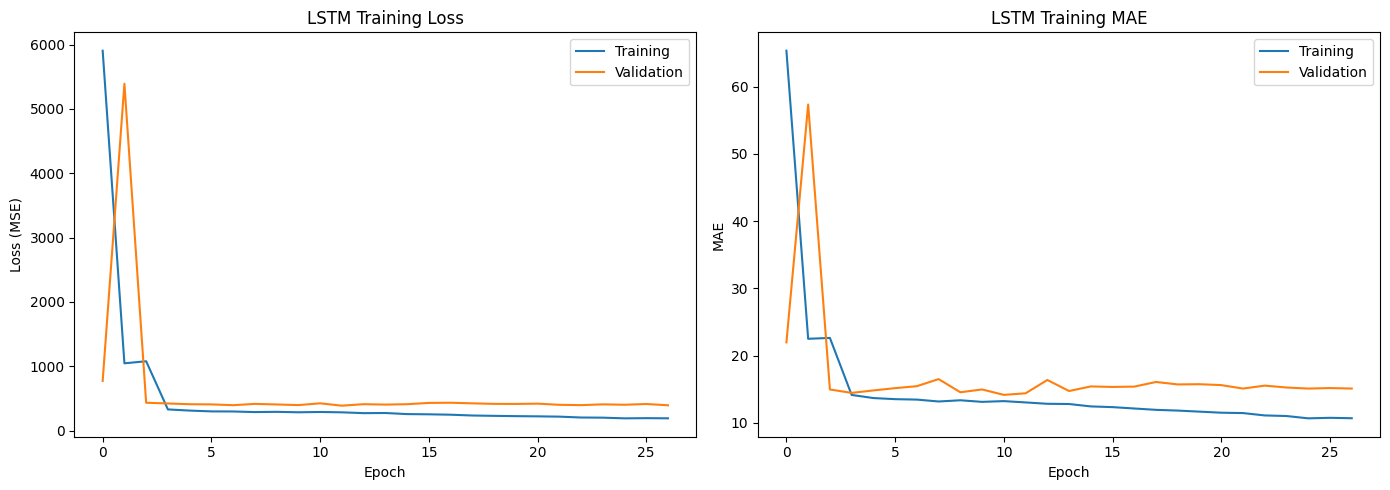

In [14]:
# Training visualisieren
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history.history['loss'], label='Training')
axes[0].plot(history.history['val_loss'], label='Validation')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (MSE)')
axes[0].set_title('LSTM Training Loss')
axes[0].legend()

axes[1].plot(history.history['mae'], label='Training')
axes[1].plot(history.history['val_mae'], label='Validation')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MAE')
axes[1].set_title('LSTM Training MAE')
axes[1].legend()

plt.tight_layout()
plt.savefig('../models/trained/lstm_training.png', dpi=150)
plt.show()

In [15]:
# LSTM Evaluation
y_pred_lstm = lstm_model.predict(X_test_seq, verbose=0).flatten()

print("\n=== LSTM ===")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_seq, y_pred_lstm)):.2f}")
print(f"MAE: {mean_absolute_error(y_test_seq, y_pred_lstm):.2f}")
print(f"R²: {r2_score(y_test_seq, y_pred_lstm):.4f}")


=== LSTM ===
RMSE: 19.17
MAE: 13.03
R²: 0.7882


## 5. CNN-LSTM Hybrid

In [16]:
def create_cnn_lstm_model(sequence_length, n_features):
    """
    Erstellt ein CNN-LSTM Hybrid-Modell.
    CNN extrahiert lokale Features, LSTM lernt temporale Abhängigkeiten.
    """
    model = keras.Sequential([
        layers.Input(shape=(sequence_length, n_features)),
        
        # 1D CNN für lokale Feature-Extraktion
        layers.Conv1D(64, kernel_size=3, activation='relu', padding='same'),
        layers.MaxPooling1D(pool_size=2),
        layers.Conv1D(32, kernel_size=3, activation='relu', padding='same'),
        
        # LSTM für temporale Patterns
        layers.LSTM(32, return_sequences=False),
        layers.Dropout(0.3),
        
        # Dense für Regression
        layers.Dense(32, activation='relu'),
        layers.Dense(1)
    ])
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )
    
    return model

cnn_lstm_model = create_cnn_lstm_model(SEQUENCE_LENGTH, n_features)
cnn_lstm_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 30, 64)         │         2,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 15, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 15, 32)         │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,529 (72.38 KB)

 Trainable params: 18,529 (72.38 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# Training
print("Training CNN-LSTM...")

history_cnn = cnn_lstm_model.fit(
    X_train_seq, y_train_seq,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Training CNN-LSTM...
Epoch 1/100


  1/172 ━━━━━━━━━━━━━━━━━━━━ 8:48 3s/step - loss: 12366.2900 - mae: 106.2864

  5/172 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 11760.3850 - mae: 101.8626

 11/172 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 11219.3622 - mae: 98.2644 

 18/172 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 11082.4842 - mae: 97.4059

 25/172 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 11007.4074 - mae: 96.9413 

 31/172 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 10925.6165 - mae: 96.4763

 37/172 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 10840.9559 - mae: 96.0203

 43/172 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 10768.0172 - mae: 95.6594

 50/172 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 10687.6680 - mae: 95.2540

 56/172 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 10618.6684 - mae: 94.9006

 62/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 10547.8751 - mae: 94.5345

 69/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 10463.4799 - mae: 94.0862

 75/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 10392.7566 - mae: 93.7129

 82/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 10309.8089 - mae: 93.2674

 88/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 10240.9597 - mae: 92.8970

 94/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 10173.2338 - mae: 92.5334

100/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 10104.9371 - mae: 92.1607

106/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 10036.7248 - mae: 91.7872

112/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 9968.8708 - mae: 91.4148 

119/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 9889.4973 - mae: 90.9782

125/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 9822.3383 - mae: 90.6108

132/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 9743.6142 - mae: 90.1772

139/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 9664.7175 - mae: 89.7415

145/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 9597.5362 - mae: 89.3704

151/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 9530.5659 - mae: 88.9999

157/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 9463.9846 - mae: 88.6322

163/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 9397.3587 - mae: 88.2627

170/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 9319.8539 - mae: 87.8317

172/172 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 7421.4893 - mae: 77.2562 - val_loss: 3000.2485 - val_mae: 48.3935 - learning_rate: 0.0010


Epoch 2/100


  1/172 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 2929.6206 - mae: 45.7106

  8/172 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3276.6047 - mae: 50.4419 

 15/172 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3234.3180 - mae: 50.5137

 21/172 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3210.6426 - mae: 50.5404

 27/172 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3184.3941 - mae: 50.4372

 34/172 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3151.9307 - mae: 50.2667

 40/172 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3118.2004 - mae: 50.0493

 46/172 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3078.6980 - mae: 49.7498

 52/172 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3037.0407 - mae: 49.4097

 57/172 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3002.5265 - mae: 49.1250

 64/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2953.9651 - mae: 48.7112

 70/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2912.3388 - mae: 48.3471

 76/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2871.1905 - mae: 47.9775

 82/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2830.2941 - mae: 47.6001

 88/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2789.8543 - mae: 47.2208

 94/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2749.8094 - mae: 46.8362

100/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2710.4922 - mae: 46.4525

107/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2665.3828 - mae: 46.0041

113/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2627.3596 - mae: 45.6171

119/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2590.4108 - mae: 45.2375

124/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2560.3133 - mae: 44.9249

128/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2536.7619 - mae: 44.6786

134/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2502.1007 - mae: 44.3111

140/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2468.3818 - mae: 43.9485

145/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2441.0451 - mae: 43.6520

151/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2409.0837 - mae: 43.3020

157/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2377.9660 - mae: 42.9575

163/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2347.8131 - mae: 42.6206

169/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2318.5064 - mae: 42.2902

172/172 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1495.2699 - mae: 32.9444 - val_loss: 502.7918 - val_mae: 19.9962 - learning_rate: 0.0010


Epoch 3/100


  1/172 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 352.9943 - mae: 15.1009

  8/172 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 461.5086 - mae: 17.9248 

 14/172 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 492.6221 - mae: 18.5628

 21/172 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 506.9530 - mae: 18.8459

 28/172 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 511.7450 - mae: 18.9125

 36/172 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 511.6969 - mae: 18.8832

 43/172 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 511.6134 - mae: 18.8557

 50/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 509.5436 - mae: 18.7929

 55/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 507.4846 - mae: 18.7347

 61/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 505.1954 - mae: 18.6699

 67/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 503.4665 - mae: 18.6189

 75/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 500.3998 - mae: 18.5363

 81/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 497.7866 - mae: 18.4709

 87/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 495.0477 - mae: 18.4034

 93/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 492.4590 - mae: 18.3400

 98/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 490.4809 - mae: 18.2909

104/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 488.2656 - mae: 18.2345

111/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 485.9559 - mae: 18.1750

118/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 483.9894 - mae: 18.1225

124/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 482.2180 - mae: 18.0755

130/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 480.3628 - mae: 18.0268

136/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 478.5269 - mae: 17.9782

142/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 476.7215 - mae: 17.9305

149/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 474.6923 - mae: 17.8779

155/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 473.0002 - mae: 17.8343

161/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 471.3397 - mae: 17.7911

168/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 469.5000 - mae: 17.7427

172/172 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 425.2601 - mae: 16.5945 - val_loss: 384.6826 - val_mae: 15.2122 - learning_rate: 0.0010


Epoch 4/100


  1/172 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 401.8406 - mae: 16.7197

  8/172 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 387.6959 - mae: 16.3938 

 14/172 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 383.5055 - mae: 15.9924

 20/172 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 383.1532 - mae: 15.8521

 26/172 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 382.4671 - mae: 15.7673

 31/172 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 382.6423 - mae: 15.7322

 37/172 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 382.0989 - mae: 15.7000

 44/172 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 381.4328 - mae: 15.6687

 51/172 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 380.4426 - mae: 15.6213

 58/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 380.3333 - mae: 15.5937

 65/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 380.2798 - mae: 15.5712

 71/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 380.0462 - mae: 15.5534

 76/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 379.9498 - mae: 15.5425

 81/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 379.8230 - mae: 15.5325

 87/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 379.8172 - mae: 15.5260

 92/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 379.8116 - mae: 15.5209

 98/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 379.8001 - mae: 15.5156

104/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 379.7197 - mae: 15.5089

110/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 379.4958 - mae: 15.5009

116/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 379.2335 - mae: 15.4924

122/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 378.8953 - mae: 15.4822

129/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 378.4926 - mae: 15.4701

135/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 378.0765 - mae: 15.4591

141/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 377.7499 - mae: 15.4498

145/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 377.5384 - mae: 15.4437

150/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 377.2556 - mae: 15.4358

156/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 376.9010 - mae: 15.4258

163/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 376.4872 - mae: 15.4141

169/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 376.1539 - mae: 15.4046

172/172 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 366.9096 - mae: 15.1451 - val_loss: 401.1129 - val_mae: 14.5176 - learning_rate: 0.0010


Epoch 5/100


  1/172 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 296.9027 - mae: 13.9026

  8/172 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 302.4217 - mae: 13.8229 

 14/172 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 326.0328 - mae: 14.1728

 20/172 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 336.3956 - mae: 14.3278

 26/172 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 340.1520 - mae: 14.3931

 31/172 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 344.6341 - mae: 14.4690

 36/172 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 348.9906 - mae: 14.5476

 41/172 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 351.3906 - mae: 14.5967

 47/172 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 353.3104 - mae: 14.6446

 52/172 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 355.3798 - mae: 14.6921

 58/172 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 357.6701 - mae: 14.7446

 65/172 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 359.6201 - mae: 14.7912 

 71/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 360.8859 - mae: 14.8212

 78/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 362.0780 - mae: 14.8522

 85/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 363.0896 - mae: 14.8797

 91/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 363.6662 - mae: 14.8965

 98/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 364.6012 - mae: 14.9200

105/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 365.3660 - mae: 14.9398

111/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 365.8767 - mae: 14.9538

117/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 366.2166 - mae: 14.9637

123/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 366.3089 - mae: 14.9681

129/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 366.2547 - mae: 14.9699

135/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 366.1427 - mae: 14.9706

141/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 366.0643 - mae: 14.9715

147/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 365.9983 - mae: 14.9726

152/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 365.9770 - mae: 14.9744

158/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 366.0069 - mae: 14.9777

164/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 366.1098 - mae: 14.9821

171/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 366.1826 - mae: 14.9866

172/172 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 367.5001 - mae: 15.0893 - val_loss: 401.7405 - val_mae: 14.6885 - learning_rate: 0.0010


Epoch 6/100


  1/172 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 315.4874 - mae: 14.4247

  8/172 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 303.5694 - mae: 13.6287 

 15/172 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 320.7879 - mae: 14.0041

 21/172 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 327.0965 - mae: 14.1990

 27/172 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 331.7014 - mae: 14.3242

 33/172 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 337.7922 - mae: 14.4674

 40/172 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 341.6355 - mae: 14.5629

 47/172 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 343.8334 - mae: 14.6221

 53/172 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 345.0721 - mae: 14.6587

 59/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 346.3037 - mae: 14.6989

 65/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 346.8271 - mae: 14.7231

 71/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 347.1547 - mae: 14.7400

 77/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 347.2119 - mae: 14.7489

 83/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 347.0972 - mae: 14.7534

 88/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 347.1902 - mae: 14.7597

 93/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 347.4014 - mae: 14.7668

 99/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 347.7503 - mae: 14.7755

105/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 348.0958 - mae: 14.7852

111/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 348.4194 - mae: 14.7947

117/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 348.6319 - mae: 14.8019

123/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 348.7821 - mae: 14.8069

129/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 348.9937 - mae: 14.8129

136/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 349.1285 - mae: 14.8170

143/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 349.1263 - mae: 14.8185

149/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 349.0849 - mae: 14.8194

155/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 349.0748 - mae: 14.8208

161/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 349.1054 - mae: 14.8227

168/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 349.1128 - mae: 14.8242

172/172 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 347.7734 - mae: 14.8314 - val_loss: 383.5782 - val_mae: 14.9380 - learning_rate: 0.0010


Epoch 7/100


  1/172 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - loss: 315.0838 - mae: 14.8149

  7/172 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 310.2060 - mae: 14.2523

 14/172 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 322.0075 - mae: 14.4159 

 21/172 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 324.8990 - mae: 14.4773

 28/172 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 327.5658 - mae: 14.5267

 34/172 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 330.1375 - mae: 14.5690

 41/172 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 332.7175 - mae: 14.6146

 48/172 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 334.7410 - mae: 14.6584

 55/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 336.9430 - mae: 14.7082

 62/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 338.6725 - mae: 14.7482

 68/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 339.4806 - mae: 14.7689

 74/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 339.8842 - mae: 14.7803

 81/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 340.0566 - mae: 14.7875

 88/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 340.3523 - mae: 14.7957

 93/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 340.5815 - mae: 14.8008

100/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 340.7715 - mae: 14.8053

107/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 340.9384 - mae: 14.8075

114/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 340.9553 - mae: 14.8067

120/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 341.0562 - mae: 14.8078

127/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 341.1002 - mae: 14.8070

134/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 341.1367 - mae: 14.8046

141/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 341.1082 - mae: 14.7999

148/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 341.0547 - mae: 14.7953

156/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 340.8873 - mae: 14.7882

163/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 340.7294 - mae: 14.7820

170/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 340.5970 - mae: 14.7765

172/172 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 336.5194 - mae: 14.6179 - val_loss: 390.6447 - val_mae: 14.6894 - learning_rate: 0.0010


Epoch 8/100


  1/172 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 345.9969 - mae: 15.8421

  9/172 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 377.2883 - mae: 15.5455 

 16/172 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 360.9569 - mae: 15.1276

 23/172 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 353.4401 - mae: 14.9173

 30/172 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 347.0516 - mae: 14.7446

 37/172 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 342.3245 - mae: 14.6126

 43/172 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 339.7659 - mae: 14.5419

 50/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 337.6304 - mae: 14.4819

 57/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 336.9307 - mae: 14.4619

 64/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 337.2724 - mae: 14.4661

 70/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 337.9378 - mae: 14.4778

 75/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 338.7016 - mae: 14.4916

 81/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 339.4920 - mae: 14.5046

 87/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 340.1300 - mae: 14.5170

 93/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 340.5085 - mae: 14.5243

100/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 340.7915 - mae: 14.5290

106/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 341.0517 - mae: 14.5342

113/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 341.2593 - mae: 14.5397

120/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 341.2339 - mae: 14.5399

127/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 341.1148 - mae: 14.5377

134/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 341.0445 - mae: 14.5381

140/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 341.0488 - mae: 14.5400

146/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 341.0433 - mae: 14.5416

153/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 341.0054 - mae: 14.5428

160/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 340.8566 - mae: 14.5414

166/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 340.8126 - mae: 14.5421

172/172 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 338.2054 - mae: 14.5311 - val_loss: 389.5656 - val_mae: 15.1501 - learning_rate: 0.0010


Epoch 9/100


  1/172 ━━━━━━━━━━━━━━━━━━━━ 2:53 1s/step - loss: 256.1594 - mae: 13.2014

  8/172 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 298.4535 - mae: 14.0742 

 16/172 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 309.0805 - mae: 14.1773

 23/172 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 315.6816 - mae: 14.2788

 30/172 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 322.2728 - mae: 14.3790

 36/172 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 326.3556 - mae: 14.4485

 42/172 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 330.3537 - mae: 14.5280

 48/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 332.8923 - mae: 14.5759

 54/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 334.8400 - mae: 14.6088

 60/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 336.5114 - mae: 14.6405

 66/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 337.6914 - mae: 14.6633

 73/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 339.0972 - mae: 14.6927

 79/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 339.6700 - mae: 14.7036

 86/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 339.8603 - mae: 14.7061

 92/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 339.8229 - mae: 14.7059

 98/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 339.7448 - mae: 14.7054

104/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 339.7346 - mae: 14.7065

111/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 340.0274 - mae: 14.7131

117/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 340.2111 - mae: 14.7172

123/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 340.3918 - mae: 14.7210

128/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 340.5197 - mae: 14.7238

134/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 340.7578 - mae: 14.7282

140/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 341.0166 - mae: 14.7325

146/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 341.2275 - mae: 14.7368

153/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 341.3701 - mae: 14.7402

160/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 341.5235 - mae: 14.7440

166/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 341.6239 - mae: 14.7465

172/172 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 343.3430 - mae: 14.7983 - val_loss: 376.2583 - val_mae: 14.5799 - learning_rate: 0.0010


Epoch 10/100


  1/172 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 309.1193 - mae: 14.7077

  7/172 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 320.1586 - mae: 14.5084 

 13/172 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 324.1864 - mae: 14.4747

 20/172 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 327.6888 - mae: 14.5021

 26/172 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 327.8295 - mae: 14.5037

 33/172 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 327.8001 - mae: 14.5069

 40/172 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 328.0734 - mae: 14.5090

 47/172 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 327.7511 - mae: 14.4926

 54/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 327.4227 - mae: 14.4775

 61/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 327.0949 - mae: 14.4643

 68/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 327.1124 - mae: 14.4608

 75/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 327.3231 - mae: 14.4653

 81/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 327.2170 - mae: 14.4623

 87/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 327.0540 - mae: 14.4576

 94/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 326.9852 - mae: 14.4546

100/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 327.0187 - mae: 14.4546

106/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 327.2301 - mae: 14.4570

112/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 327.4421 - mae: 14.4577

118/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 327.8527 - mae: 14.4617

124/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 328.2449 - mae: 14.4653

130/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 328.6175 - mae: 14.4690

136/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 328.9313 - mae: 14.4722

142/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 329.1388 - mae: 14.4738

148/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 329.2871 - mae: 14.4749

155/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 329.3929 - mae: 14.4746

161/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 329.4013 - mae: 14.4731

168/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 329.3565 - mae: 14.4705

172/172 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 327.9451 - mae: 14.4030 - val_loss: 383.9192 - val_mae: 14.3333 - learning_rate: 0.0010


Epoch 11/100


  1/172 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 265.6071 - mae: 13.0069

  7/172 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 281.3010 - mae: 13.2443 

 13/172 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 301.1275 - mae: 13.6634

 20/172 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 310.7095 - mae: 13.8693

 26/172 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 317.5293 - mae: 14.0072

 32/172 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 320.5885 - mae: 14.0680

 38/172 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 323.5926 - mae: 14.1477

 44/172 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 325.7103 - mae: 14.2072

 50/172 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 326.8211 - mae: 14.2368

 56/172 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 327.0568 - mae: 14.2476

 62/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 326.7863 - mae: 14.2429

 67/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 326.6605 - mae: 14.2427

 73/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 326.3495 - mae: 14.2397

 79/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 326.4566 - mae: 14.2440

 84/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 326.7971 - mae: 14.2534

 91/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 327.4565 - mae: 14.2709

 97/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 327.8721 - mae: 14.2830

103/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 328.1006 - mae: 14.2913

109/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 328.2066 - mae: 14.2959

114/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 328.3697 - mae: 14.3003

120/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 328.6266 - mae: 14.3076

126/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 329.0100 - mae: 14.3185

134/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 329.3877 - mae: 14.3305

142/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 329.5845 - mae: 14.3383

149/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 329.8512 - mae: 14.3471

156/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 330.1564 - mae: 14.3574

163/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 330.4213 - mae: 14.3669

169/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 330.6075 - mae: 14.3739

172/172 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 335.3520 - mae: 14.5521 - val_loss: 385.2614 - val_mae: 14.8812 - learning_rate: 0.0010


Epoch 12/100


  1/172 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 464.0924 - mae: 17.5059

  9/172 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 364.7085 - mae: 15.2722 

 16/172 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 338.9644 - mae: 14.7510

 22/172 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 330.7545 - mae: 14.6081

 29/172 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 325.7590 - mae: 14.5103

 36/172 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 322.6328 - mae: 14.4362

 43/172 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 321.1915 - mae: 14.3971

 50/172 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 321.0761 - mae: 14.3747

 57/172 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 320.8239 - mae: 14.3517

 64/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 321.1550 - mae: 14.3446

 71/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 321.1515 - mae: 14.3336

 78/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 321.1280 - mae: 14.3234

 85/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 321.1378 - mae: 14.3143

 92/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 321.1294 - mae: 14.3062

 99/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 321.1794 - mae: 14.3012

106/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 321.3239 - mae: 14.3001

113/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 321.5839 - mae: 14.3019

119/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 321.8305 - mae: 14.3056

125/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 322.0253 - mae: 14.3092

131/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 322.1311 - mae: 14.3112

138/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 322.1509 - mae: 14.3112

144/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 322.1123 - mae: 14.3103

150/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 322.1097 - mae: 14.3110

156/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 322.1440 - mae: 14.3124

163/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 322.1517 - mae: 14.3133

169/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 322.1532 - mae: 14.3137

172/172 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 322.1156 - mae: 14.3175 - val_loss: 392.3367 - val_mae: 16.0168 - learning_rate: 0.0010


Epoch 13/100


  1/172 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 358.0313 - mae: 16.1153

  7/172 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 353.4429 - mae: 15.5160 

 14/172 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 357.5493 - mae: 15.4194

 21/172 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 352.5678 - mae: 15.2199

 27/172 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 351.1446 - mae: 15.1451

 32/172 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 350.8101 - mae: 15.1013

 37/172 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 348.9809 - mae: 15.0280

 43/172 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 347.1596 - mae: 14.9599

 49/172 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 345.7697 - mae: 14.9114

 54/172 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 344.7340 - mae: 14.8759

 60/172 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 343.9509 - mae: 14.8447

 66/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 343.2979 - mae: 14.8175

 73/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 342.5207 - mae: 14.7844

 79/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 341.6395 - mae: 14.7541

 86/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 340.8853 - mae: 14.7278

 94/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 340.2134 - mae: 14.7030

101/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 339.6756 - mae: 14.6832

108/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 339.1730 - mae: 14.6652

115/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 338.5874 - mae: 14.6472

122/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 337.9903 - mae: 14.6299

129/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 337.4738 - mae: 14.6155

136/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 336.9958 - mae: 14.6025

142/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 336.6247 - mae: 14.5925

148/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 336.2443 - mae: 14.5822

154/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 335.8745 - mae: 14.5725

161/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 335.3967 - mae: 14.5604

167/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 334.9278 - mae: 14.5484

172/172 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 323.4000 - mae: 14.2427 - val_loss: 406.2847 - val_mae: 15.6856 - learning_rate: 0.0010


Epoch 14/100


  1/172 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 232.3275 - mae: 11.8580

  7/172 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 309.5699 - mae: 13.9666 

 13/172 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 318.3608 - mae: 14.2228

 20/172 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 319.4883 - mae: 14.2565

 26/172 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 320.6600 - mae: 14.2485

 32/172 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 321.5298 - mae: 14.2555

 38/172 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 322.2007 - mae: 14.2664

 44/172 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 322.3512 - mae: 14.2733

 51/172 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 321.7354 - mae: 14.2660

 58/172 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 320.4191 - mae: 14.2387

 65/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 319.1733 - mae: 14.2137

 71/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 318.6815 - mae: 14.2039

 77/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 318.3002 - mae: 14.1984

 84/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 317.8308 - mae: 14.1913

 91/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 317.4772 - mae: 14.1862

 98/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 317.1796 - mae: 14.1820

104/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 316.8390 - mae: 14.1758

111/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 316.4686 - mae: 14.1687

117/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 316.2202 - mae: 14.1626

123/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 315.9453 - mae: 14.1547

129/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 315.6177 - mae: 14.1450

135/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 315.2418 - mae: 14.1345

141/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 314.8291 - mae: 14.1232

148/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 314.2793 - mae: 14.1089

154/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 313.7841 - mae: 14.0961

160/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 313.3482 - mae: 14.0851

165/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 312.9715 - mae: 14.0760

171/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 312.4912 - mae: 14.0641

172/172 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 299.5944 - mae: 13.7413 - val_loss: 448.2909 - val_mae: 15.9592 - learning_rate: 0.0010


Epoch 15/100


  1/172 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - loss: 294.0461 - mae: 13.5159

  7/172 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 309.2427 - mae: 14.1551 

 12/172 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 301.3412 - mae: 13.9137

 18/172 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 297.2821 - mae: 13.7748 

 24/172 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 295.3314 - mae: 13.7150

 30/172 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 294.5854 - mae: 13.6861

 35/172 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 293.6535 - mae: 13.6522

 41/172 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 292.3532 - mae: 13.6036

 47/172 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 290.8684 - mae: 13.5524

 53/172 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 289.3201 - mae: 13.5025

 59/172 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 288.0892 - mae: 13.4617 

 65/172 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 287.3134 - mae: 13.4368

 71/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 286.9197 - mae: 13.4225

 78/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 286.5368 - mae: 13.4077

 84/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 286.3897 - mae: 13.4001

 90/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 286.3392 - mae: 13.3957

 97/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 286.3262 - mae: 13.3928

104/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 286.3726 - mae: 13.3919

110/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 286.4821 - mae: 13.3930

117/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 286.6106 - mae: 13.3947

123/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 286.6731 - mae: 13.3963

129/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 286.7517 - mae: 13.3993

135/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 286.8223 - mae: 13.4024

141/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 286.8798 - mae: 13.4044

147/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 286.9268 - mae: 13.4056

153/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 286.8801 - mae: 13.4040

159/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 286.9038 - mae: 13.4039

166/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 286.9052 - mae: 13.4036

172/172 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 286.4674 - mae: 13.3848 - val_loss: 425.7443 - val_mae: 15.4139 - learning_rate: 5.0000e-04


Epoch 16/100


  1/172 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 427.0257 - mae: 15.5600

  8/172 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 335.9417 - mae: 13.8567 

 15/172 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 313.1177 - mae: 13.6118

 22/172 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 306.6591 - mae: 13.5415

 29/172 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 303.4574 - mae: 13.5145

 36/172 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 300.8856 - mae: 13.5149

 43/172 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 298.4970 - mae: 13.5105

 49/172 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 296.7809 - mae: 13.5015

 55/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 295.4933 - mae: 13.4941

 61/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 294.4635 - mae: 13.4862

 68/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 292.9659 - mae: 13.4655

 75/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 291.5557 - mae: 13.4458

 82/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 290.4337 - mae: 13.4295

 89/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 289.5629 - mae: 13.4184

 96/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 288.9221 - mae: 13.4115

103/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 288.1716 - mae: 13.4028

110/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 287.4458 - mae: 13.3927

117/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 286.9282 - mae: 13.3855

124/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 286.5023 - mae: 13.3800

131/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 286.2352 - mae: 13.3783

139/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 285.8752 - mae: 13.3747

146/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 285.4380 - mae: 13.3678

152/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 285.1113 - mae: 13.3622

158/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 284.7646 - mae: 13.3555

164/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 284.4026 - mae: 13.3480

170/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 284.0282 - mae: 13.3407

172/172 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 272.5841 - mae: 13.1082 - val_loss: 422.9000 - val_mae: 15.3904 - learning_rate: 5.0000e-04


Epoch 17/100


  1/172 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 242.6195 - mae: 13.3528

  7/172 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 260.3557 - mae: 13.3865 

 13/172 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 265.7128 - mae: 13.2955

 20/172 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 268.5194 - mae: 13.1729

 27/172 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 269.5069 - mae: 13.1096

 34/172 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 270.5861 - mae: 13.0877

 40/172 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 271.7720 - mae: 13.0855

 46/172 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 272.1283 - mae: 13.0757

 52/172 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 272.4390 - mae: 13.0686

 58/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 272.6209 - mae: 13.0622

 64/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 272.3631 - mae: 13.0474

 71/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 271.9968 - mae: 13.0305

 77/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 271.5599 - mae: 13.0142

 83/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 271.1141 - mae: 12.9986

 90/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 270.8913 - mae: 12.9852

 97/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 270.5633 - mae: 12.9711

104/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 270.4063 - mae: 12.9611

110/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 270.2403 - mae: 12.9526

116/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 270.1003 - mae: 12.9444

122/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 269.9644 - mae: 12.9368

128/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 269.7918 - mae: 12.9288

134/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 269.5712 - mae: 12.9203

140/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 269.3312 - mae: 12.9117

147/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 268.9699 - mae: 12.9001

154/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 268.6044 - mae: 12.8883

161/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 268.2541 - mae: 12.8768

167/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 267.9639 - mae: 12.8674

172/172 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 262.0335 - mae: 12.6492 - val_loss: 424.7896 - val_mae: 15.2362 - learning_rate: 5.0000e-04


Epoch 18/100


  1/172 ━━━━━━━━━━━━━━━━━━━━ 2:40 936ms/step - loss: 416.3260 - mae: 16.4198

  7/172 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 317.8021 - mae: 14.2459   

 13/172 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 303.4378 - mae: 13.9059

 18/172 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 294.5586 - mae: 13.6901

 23/172 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 288.9194 - mae: 13.5238

 30/172 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 282.4859 - mae: 13.3421 

 35/172 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 277.9680 - mae: 13.2168

 41/172 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 274.2694 - mae: 13.1066 

 48/172 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 271.3049 - mae: 13.0185

 55/172 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 269.0700 - mae: 12.9565

 61/172 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 267.3690 - mae: 12.9142

 67/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 266.0959 - mae: 12.8808

 74/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 265.1874 - mae: 12.8577

 81/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 264.4653 - mae: 12.8414

 88/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 263.8243 - mae: 12.8261

 95/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 263.2500 - mae: 12.8106

102/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 262.7397 - mae: 12.7960

109/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 262.2169 - mae: 12.7816

116/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 261.6926 - mae: 12.7673

123/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 261.2312 - mae: 12.7551

130/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 260.8182 - mae: 12.7440

137/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 260.4784 - mae: 12.7347

144/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 260.1388 - mae: 12.7254

151/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 259.7578 - mae: 12.7146

157/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 259.5122 - mae: 12.7066

164/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 259.2095 - mae: 12.6970

170/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 258.9770 - mae: 12.6891

172/172 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 252.5950 - mae: 12.4758 - val_loss: 421.8794 - val_mae: 15.6374 - learning_rate: 5.0000e-04


Epoch 19/100


  1/172 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 223.7742 - mae: 11.8188

  8/172 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 227.0520 - mae: 11.7474 

 16/172 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 225.5723 - mae: 11.7181

 24/172 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 230.0549 - mae: 11.8445

 31/172 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 233.1521 - mae: 11.9256

 38/172 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 235.2556 - mae: 11.9842

 45/172 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 235.9680 - mae: 12.0103

 53/172 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 236.3210 - mae: 12.0203

 60/172 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 237.2391 - mae: 12.0422

 67/172 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 237.6894 - mae: 12.0547

 74/172 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 237.9544 - mae: 12.0640

 81/172 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 238.4183 - mae: 12.0762

 88/172 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 238.8214 - mae: 12.0862

 95/172 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 239.2020 - mae: 12.0965

101/172 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 239.4464 - mae: 12.1040

108/172 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 239.7424 - mae: 12.1132

115/172 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 240.0111 - mae: 12.1224

122/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 240.3218 - mae: 12.1323

128/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 240.5829 - mae: 12.1409

135/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 240.8981 - mae: 12.1515

142/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 241.2018 - mae: 12.1614

148/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 241.3817 - mae: 12.1671

155/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 241.6209 - mae: 12.1745

161/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 241.7592 - mae: 12.1795

168/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 241.8627 - mae: 12.1842

172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 245.2261 - mae: 12.3251 - val_loss: 404.5342 - val_mae: 14.7384 - learning_rate: 5.0000e-04


Epoch 20/100


  1/172 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 249.6046 - mae: 12.9659

  7/172 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 244.1125 - mae: 12.4938 

 13/172 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 239.8210 - mae: 12.2837

 19/172 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 238.6889 - mae: 12.2346

 26/172 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 236.8113 - mae: 12.1755

 33/172 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 234.7236 - mae: 12.1247

 40/172 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 234.0298 - mae: 12.0932

 47/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 233.0972 - mae: 12.0583

 54/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 232.6934 - mae: 12.0334

 61/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 232.5371 - mae: 12.0131

 68/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 232.3620 - mae: 11.9949

 74/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 232.3292 - mae: 11.9853

 81/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 232.3496 - mae: 11.9799

 88/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 232.5490 - mae: 11.9815

 95/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 232.8048 - mae: 11.9858

102/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 233.2712 - mae: 11.9954

108/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 233.7151 - mae: 12.0049

115/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 234.1644 - mae: 12.0154

122/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 234.5591 - mae: 12.0241

129/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 234.8795 - mae: 12.0306

136/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 235.2015 - mae: 12.0375

144/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 235.5369 - mae: 12.0439

151/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 235.7842 - mae: 12.0485

159/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 236.0680 - mae: 12.0543

165/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 236.2151 - mae: 12.0572

171/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 236.3496 - mae: 12.0602

172/172 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 239.4042 - mae: 12.1276 - val_loss: 407.2901 - val_mae: 14.9157 - learning_rate: 2.5000e-04


Epoch 21/100


  1/172 ━━━━━━━━━━━━━━━━━━━━ 3:01 1s/step - loss: 198.4199 - mae: 10.7088

  7/172 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 229.7698 - mae: 11.6757 

 13/172 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 236.0262 - mae: 11.8998

 19/172 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 236.4002 - mae: 11.9654

 25/172 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 236.9432 - mae: 11.9938

 31/172 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 238.2712 - mae: 12.0234

 37/172 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 239.0274 - mae: 12.0418

 43/172 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 239.5963 - mae: 12.0570

 49/172 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 239.9562 - mae: 12.0632

 53/172 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 240.0201 - mae: 12.0658

 59/172 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 239.8575 - mae: 12.0652

 65/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 239.4926 - mae: 12.0561

 71/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 238.8473 - mae: 12.0408

 76/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 238.4228 - mae: 12.0321

 80/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 238.1980 - mae: 12.0270

 86/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 237.8386 - mae: 12.0204

 92/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 237.5401 - mae: 12.0154

 99/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 237.1822 - mae: 12.0087

105/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 236.9324 - mae: 12.0045

111/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 236.6588 - mae: 11.9991

117/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 236.3737 - mae: 11.9934

122/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 236.1514 - mae: 11.9891

127/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 235.9782 - mae: 11.9866

132/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 235.8614 - mae: 11.9853

137/172 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 235.7152 - mae: 11.9830

142/172 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 235.5500 - mae: 11.9795

148/172 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 235.3548 - mae: 11.9752

154/172 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 235.1769 - mae: 11.9719

159/172 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 235.0621 - mae: 11.9698

166/172 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 234.8497 - mae: 11.9655

172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 234.6640 - mae: 11.9617

172/172 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 229.0112 - mae: 11.8430 - val_loss: 405.4712 - val_mae: 14.7885 - learning_rate: 2.5000e-04


Epoch 22/100


  1/172 ━━━━━━━━━━━━━━━━━━━━ 2:10 765ms/step - loss: 175.1081 - mae: 10.6753

  7/172 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 192.5037 - mae: 10.7408    

 13/172 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 199.3597 - mae: 11.0216

 19/172 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 202.7492 - mae: 11.0945

 25/172 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 205.6711 - mae: 11.1621

 32/172 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 208.7145 - mae: 11.2290

 38/172 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 211.5736 - mae: 11.2940

 45/172 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 214.3397 - mae: 11.3629

 51/172 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 215.9208 - mae: 11.4005

 58/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 217.1488 - mae: 11.4289

 65/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 218.0847 - mae: 11.4517

 72/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 219.0737 - mae: 11.4728

 79/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 219.8208 - mae: 11.4915

 85/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 220.3177 - mae: 11.5042

 92/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 220.7098 - mae: 11.5155

 97/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 221.0191 - mae: 11.5252

103/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 221.3177 - mae: 11.5357

109/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 221.6689 - mae: 11.5492

116/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 222.1124 - mae: 11.5658

123/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 222.3842 - mae: 11.5775

130/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 222.5896 - mae: 11.5873

136/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 222.7022 - mae: 11.5941

142/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 222.8499 - mae: 11.6018

149/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 223.0691 - mae: 11.6106

155/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 223.2220 - mae: 11.6170

161/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 223.3222 - mae: 11.6219

168/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 223.4596 - mae: 11.6279

172/172 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 227.3879 - mae: 11.7934 - val_loss: 400.6723 - val_mae: 14.6955 - learning_rate: 2.5000e-04


Epoch 23/100


  1/172 ━━━━━━━━━━━━━━━━━━━━ 2:50 996ms/step - loss: 248.1805 - mae: 11.3382

  7/172 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 218.5947 - mae: 10.9898   

 14/172 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 225.4069 - mae: 11.3961 

 21/172 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 229.7848 - mae: 11.6041

 29/172 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 233.1300 - mae: 11.7346

 37/172 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 233.8091 - mae: 11.7816

 45/172 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 232.7318 - mae: 11.7860

 52/172 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 232.7463 - mae: 11.8126

 58/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 232.6634 - mae: 11.8256

 64/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 232.4661 - mae: 11.8326

 70/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 232.1954 - mae: 11.8360

 77/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 231.9272 - mae: 11.8373

 84/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 231.8055 - mae: 11.8385

 90/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 231.7137 - mae: 11.8394

 97/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 231.6352 - mae: 11.8417

104/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 231.5640 - mae: 11.8448

110/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 231.5352 - mae: 11.8490

116/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 231.4006 - mae: 11.8504

123/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 231.2215 - mae: 11.8503

130/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 230.9971 - mae: 11.8475

136/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 230.8626 - mae: 11.8458

143/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 230.7553 - mae: 11.8445

150/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 230.6497 - mae: 11.8435

157/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 230.5143 - mae: 11.8417

163/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 230.4155 - mae: 11.8409

169/172 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 230.3103 - mae: 11.8400

172/172 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 225.8483 - mae: 11.7697 - val_loss: 403.2443 - val_mae: 14.8357 - learning_rate: 2.5000e-04


Epoch 24/100


  1/172 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 326.3968 - mae: 14.0066

  8/172 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 272.3903 - mae: 12.5995 

 14/172 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 265.7652 - mae: 12.4309

 21/172 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 256.3273 - mae: 12.2249

 28/172 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 250.5199 - mae: 12.1120

 35/172 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 245.8113 - mae: 12.0080

 41/172 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 243.0628 - mae: 11.9462

 45/172 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 241.8501 - mae: 11.9216

 50/172 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 240.5751 - mae: 11.8982

 56/172 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 238.8872 - mae: 11.8678

 63/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 237.0801 - mae: 11.8373

 70/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 235.7982 - mae: 11.8201

 77/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 234.8560 - mae: 11.8123

 83/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 234.2431 - mae: 11.8079

 89/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 233.7113 - mae: 11.8034

 96/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 233.2275 - mae: 11.8007

103/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 232.8188 - mae: 11.7986

109/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 232.5837 - mae: 11.7994

116/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 232.4327 - mae: 11.8020

123/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 232.1762 - mae: 11.8001

129/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 231.9381 - mae: 11.7980

134/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 231.7102 - mae: 11.7951

140/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 231.4853 - mae: 11.7927

147/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 231.2676 - mae: 11.7904

154/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 231.0287 - mae: 11.7876

161/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 230.7614 - mae: 11.7845

168/172 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 230.4833 - mae: 11.7809

172/172 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 223.8803 - mae: 11.6853 - val_loss: 400.2038 - val_mae: 14.9677 - learning_rate: 2.5000e-04


In [18]:
# CNN-LSTM Evaluation
y_pred_cnn_lstm = cnn_lstm_model.predict(X_test_seq, verbose=0).flatten()

print("\n=== CNN-LSTM ===")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_seq, y_pred_cnn_lstm)):.2f}")
print(f"MAE: {mean_absolute_error(y_test_seq, y_pred_cnn_lstm):.2f}")
print(f"R²: {r2_score(y_test_seq, y_pred_cnn_lstm):.4f}")


=== CNN-LSTM ===
RMSE: 18.43
MAE: 12.94
R²: 0.8043


## 6. Modellvergleich

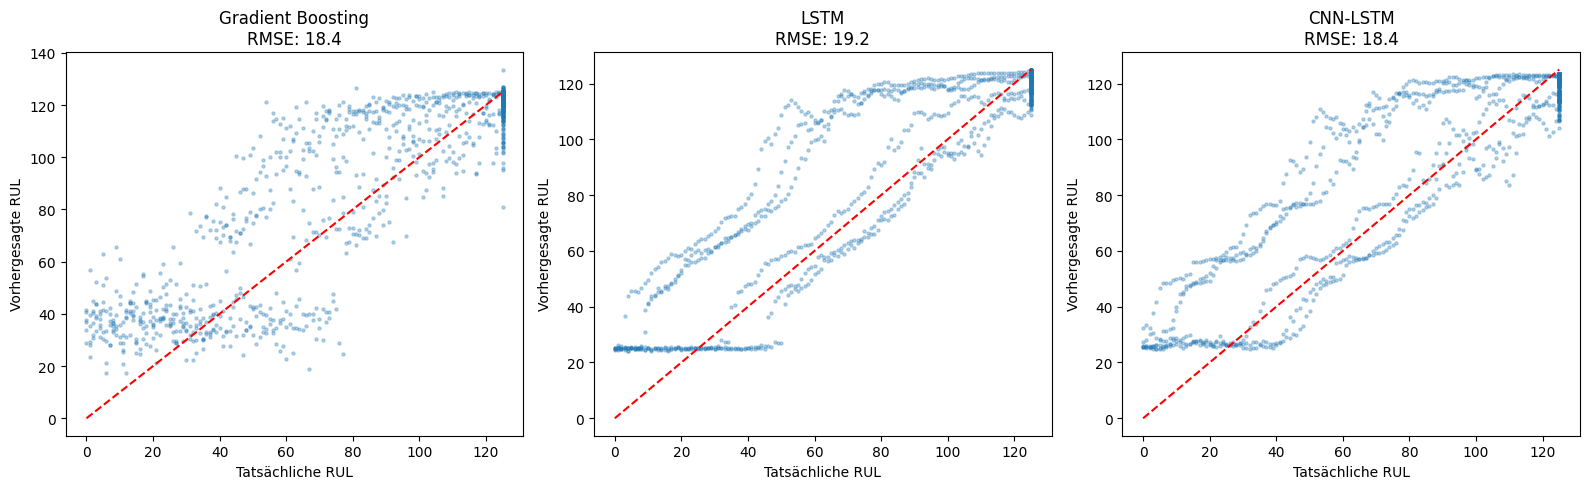

In [19]:
# Vergleich
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Gradient Boosting
axes[0].scatter(y_test, y_pred_gb, alpha=0.3, s=5)
axes[0].plot([0, RUL_CAP], [0, RUL_CAP], 'r--')
axes[0].set_xlabel('Tatsächliche RUL')
axes[0].set_ylabel('Vorhergesagte RUL')
axes[0].set_title(f'Gradient Boosting\nRMSE: {np.sqrt(mean_squared_error(y_test, y_pred_gb)):.1f}')

# LSTM
axes[1].scatter(y_test_seq, y_pred_lstm, alpha=0.3, s=5)
axes[1].plot([0, RUL_CAP], [0, RUL_CAP], 'r--')
axes[1].set_xlabel('Tatsächliche RUL')
axes[1].set_ylabel('Vorhergesagte RUL')
axes[1].set_title(f'LSTM\nRMSE: {np.sqrt(mean_squared_error(y_test_seq, y_pred_lstm)):.1f}')

# CNN-LSTM
axes[2].scatter(y_test_seq, y_pred_cnn_lstm, alpha=0.3, s=5)
axes[2].plot([0, RUL_CAP], [0, RUL_CAP], 'r--')
axes[2].set_xlabel('Tatsächliche RUL')
axes[2].set_ylabel('Vorhergesagte RUL')
axes[2].set_title(f'CNN-LSTM\nRMSE: {np.sqrt(mean_squared_error(y_test_seq, y_pred_cnn_lstm)):.1f}')

plt.tight_layout()
plt.savefig('../models/trained/rul_model_comparison.png', dpi=150)
plt.show()

In [20]:
# Zusammenfassung
print("=" * 60)
print("MODELLVERGLEICH - RUL Prediction")
print("=" * 60)

results = [
    {
        'Modell': 'Gradient Boosting',
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_gb)),
        'MAE': mean_absolute_error(y_test, y_pred_gb),
        'R²': r2_score(y_test, y_pred_gb)
    },
    {
        'Modell': 'LSTM',
        'RMSE': np.sqrt(mean_squared_error(y_test_seq, y_pred_lstm)),
        'MAE': mean_absolute_error(y_test_seq, y_pred_lstm),
        'R²': r2_score(y_test_seq, y_pred_lstm)
    },
    {
        'Modell': 'CNN-LSTM',
        'RMSE': np.sqrt(mean_squared_error(y_test_seq, y_pred_cnn_lstm)),
        'MAE': mean_absolute_error(y_test_seq, y_pred_cnn_lstm),
        'R²': r2_score(y_test_seq, y_pred_cnn_lstm)
    }
]

df_results = pd.DataFrame(results)
print(df_results.to_string(index=False))

MODELLVERGLEICH - RUL Prediction
           Modell      RMSE       MAE       R²
Gradient Boosting 18.351029 11.832849 0.798969
             LSTM 19.169614 13.033755 0.788224
         CNN-LSTM 18.427114 12.939849 0.804311


## 7. Modelle speichern

In [21]:
import joblib
import json

MODEL_DIR = '../models/trained'

# Scaler
joblib.dump(scaler, f'{MODEL_DIR}/rul_scaler.joblib')
print("✓ Scaler gespeichert")

# Gradient Boosting
joblib.dump(gb_model, f'{MODEL_DIR}/rul_gradient_boosting.joblib')
print("✓ Gradient Boosting gespeichert")

# LSTM
lstm_model.save(f'{MODEL_DIR}/rul_lstm.keras')
print("✓ LSTM gespeichert")

# CNN-LSTM
cnn_lstm_model.save(f'{MODEL_DIR}/rul_cnn_lstm.keras')
print("✓ CNN-LSTM gespeichert")

# Metadata
metadata = {
    'feature_names': feature_cols,
    'n_features': len(feature_cols),
    'sequence_length': SEQUENCE_LENGTH,
    'rul_cap': RUL_CAP,
    'scaler_mean': scaler.mean_.tolist(),
    'scaler_scale': scaler.scale_.tolist()
}

with open(f'{MODEL_DIR}/rul_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)
print("✓ Metadata gespeichert")

✓ Scaler gespeichert
✓ Gradient Boosting gespeichert
✓ LSTM gespeichert
✓ CNN-LSTM gespeichert
✓ Metadata gespeichert


In [22]:
# TensorFlow.js Export
try:
    import tensorflowjs as tfjs
    
    tfjs.converters.save_keras_model(lstm_model, f'{MODEL_DIR}/rul_lstm_tfjs')
    print("✓ LSTM als TensorFlow.js exportiert")
    
    tfjs.converters.save_keras_model(cnn_lstm_model, f'{MODEL_DIR}/rul_cnn_lstm_tfjs')
    print("✓ CNN-LSTM als TensorFlow.js exportiert")
except ImportError:
    print("⚠ tensorflowjs nicht installiert")

failed to lookup keras version from the file,
    this is likely a weight only file
✓ LSTM als TensorFlow.js exportiert
failed to lookup keras version from the file,
    this is likely a weight only file
✓ CNN-LSTM als TensorFlow.js exportiert


## 8. Beispiel: RUL Inference

In [23]:
def predict_rul(feature_sequence, model_type='lstm'):
    """
    Vorhersage der Restlebensdauer.
    
    Parameters:
    -----------
    feature_sequence : np.array
        Shape: (sequence_length, n_features) oder (n_features,) für GB
    model_type : str
        'gradient_boosting', 'lstm', oder 'cnn_lstm'
    
    Returns:
    --------
    dict mit rul_prediction und confidence
    """
    if model_type == 'gradient_boosting':
        # Nur letzten Zeitpunkt verwenden
        if len(feature_sequence.shape) == 2:
            features = feature_sequence[-1:]
        else:
            features = feature_sequence.reshape(1, -1)
        
        features_scaled = scaler.transform(features)
        rul = gb_model.predict(features_scaled)[0]
        
    else:  # LSTM or CNN-LSTM
        if len(feature_sequence.shape) == 2:
            sequence = feature_sequence.reshape(1, *feature_sequence.shape)
        else:
            sequence = feature_sequence
        
        # Skalieren
        sequence_scaled = np.zeros_like(sequence)
        for i in range(sequence.shape[1]):
            sequence_scaled[0, i, :] = scaler.transform(sequence[0, i:i+1, :])
        
        if model_type == 'lstm':
            rul = lstm_model.predict(sequence_scaled, verbose=0)[0, 0]
        else:
            rul = cnn_lstm_model.predict(sequence_scaled, verbose=0)[0, 0]
    
    return {
        'rul_prediction': float(max(0, rul)),
        'rul_unit': 'cycles',
        'model': model_type
    }

# Test
test_sequence = X_test_seq[0]  # Erste Test-Sequenz
actual_rul = y_test_seq[0]

print(f"Tatsächliche RUL: {actual_rul:.0f} Zyklen\n")

for model_type in ['gradient_boosting', 'lstm', 'cnn_lstm']:
    result = predict_rul(test_sequence, model_type)
    print(f"{model_type}: {result['rul_prediction']:.1f} Zyklen")

Tatsächliche RUL: 125 Zyklen

gradient_boosting: 77.3 Zyklen
lstm: 56.7 Zyklen
cnn_lstm: 118.3 Zyklen


## Zusammenfassung

### Trainierte RUL-Modelle

| Modell | Datei | Input | Beschreibung |
|--------|-------|-------|-------------|
| Gradient Boosting | `rul_gradient_boosting.joblib` | 1 Sample | Schnell, kein Sequenz-Input nötig |
| LSTM | `rul_lstm.keras` | 30 Samples | Lernt temporale Muster |
| CNN-LSTM | `rul_cnn_lstm.keras` | 30 Samples | Beste Genauigkeit |

### Nächste Schritte

- **04_classification.ipynb** - Fehlerklassifikation
- **05_model_export.ipynb** - Export für Node-RED